# Connect to Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [6]:
# Standard imports
import os
import re
import glob
import time
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import List, Tuple, Dict

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms
import torchvision.models as models
from PIL import Image

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4


# Data Processing

In [7]:
# !unzip -q -o "/content/drive/MyDrive/泽榕project/PlantDS_1.zip" -d "/content/drive/MyDrive/泽榕project"

Plant Growth Prediction - Data Processing
All images verified!
Dataset initialized:
   - Plants: 999 (1 to 999)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128
All images verified!
Dataset initialized:
   - Plants: 50 (1000 to 1049)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128
All images verified!
Dataset initialized:
   - Plants: 50 (1050 to 1099)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128

Dataloaders created:
   - Train batches: 125 (samples: 999)
   - Val batches: 7 (samples: 50)
   - Test batches: 7 (samples: 50)

Testing dataloader...

Batch loaded successfully:
   - Input shape: torch.Size([8, 5, 3, 128, 128])
   - Target shape: torch.Size([8, 3, 128, 128])
   - Plant IDs: [271, 475, 920, 599, 952, 104, 914, 517]

Visualizing samples...


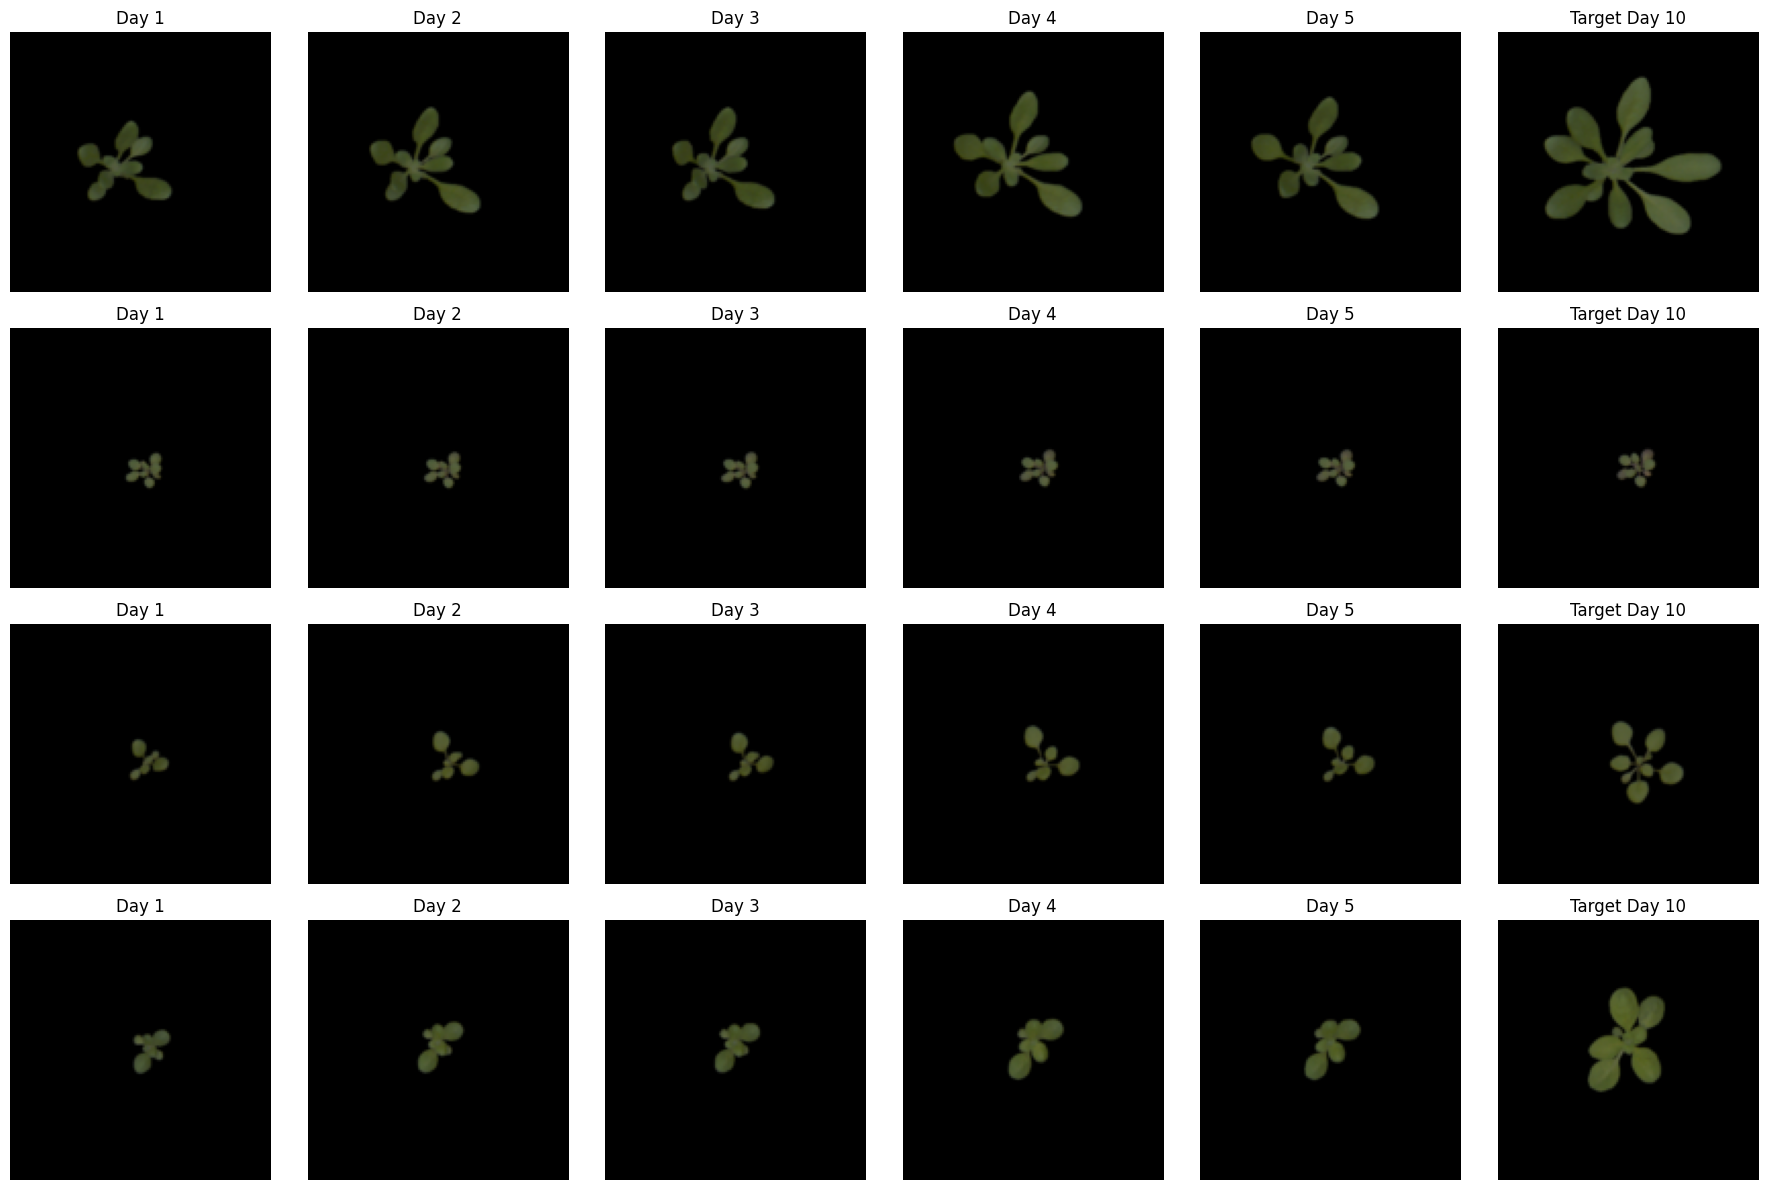


Computing dataset statistics...
   Input shape: torch.Size([50, 5, 3, 128, 128])
   Target shape: torch.Size([50, 3, 128, 128])
   Input range: [0.000, 0.592]
   Target range: [0.000, 0.596]
   Input mean: 0.024, std: 0.079
   Target mean: 0.039, std: 0.098

Data processing pipeline ready!


In [8]:
# @title
"""
Plant Growth Prediction - Data Processing
==========================================
Input: Days 1-5 images [B, 5, 3, H, W]
Output: Day 10 image [B, 3, H, W]
"""

# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Dataset configuration"""
    # Paths
    DATA_ROOT = "/content/drive/MyDrive/泽榕project/PlantDS_1/Seg"

    # Data split (out of 97 plants)
    TRAIN_PLANTS = list(range(1, 1000))
    VAL_PLANTS = list(range(1000, 1050))
    TEST_PLANTS = list(range(1050, 1100))

    # Sequence settings
    INPUT_DAYS = [1, 2, 3, 4, 5]         # Input: days 1-5
    TARGET_DAY = 10                       # Target: day 10

    # Image settings
    IMG_SIZE = 128                     # Resize images to 256x256

    # Training settings
    BATCH_SIZE = 8
    NUM_WORKERS = 0


# ============================================================================
# Dataset Class
# ============================================================================

class PlantGrowthDataset(Dataset):
    """
    Dataset for plant growth prediction

    Returns:
        input_images: [5, 3, H, W] - Days 1-5 images
        target_image: [3, H, W] - Day 10 image
        plant_id: int - Plant identifier
    """

    def __init__(self,
                 data_root: str,
                 plant_ids: List[int],
                 input_days: List[int] = [1, 2, 3, 4, 5],
                 target_day: int = 10,
                 img_size: int = 128):
        """
        Args:
            data_root: Path to raw data folder
            plant_ids: List of plant IDs to include
            input_days: List of input day numbers
            target_day: Target day number to predict
            img_size: Resize images to this size
        """
        self.data_root = Path(data_root)
        self.plant_ids = plant_ids
        self.input_days = input_days
        self.target_day = target_day
        self.img_size = img_size

        # Verify data exists
        self._verify_data()

        # Define transforms - minimal processing, just resize and convert to tensor
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor()  # Converts to [0, 1] range
        ])

        print(f"Dataset initialized:")
        print(f"   - Plants: {len(self.plant_ids)} ({min(plant_ids)} to {max(plant_ids)})")
        print(f"   - Input days: {self.input_days}")
        print(f"   - Target day: {self.target_day}")
        print(f"   - Image size: {self.img_size}x{self.img_size}")

    def _verify_data(self):
        """Verify that all required images exist"""
        missing_files = []

        for plant_id in self.plant_ids:
            # Check input days
            for day in self.input_days:
                img_path = self._get_image_path(plant_id, day)
                if not img_path.exists():
                    missing_files.append(str(img_path))

            # Check target day
            img_path = self._get_image_path(plant_id, self.target_day)
            if not img_path.exists():
                missing_files.append(str(img_path))

        if missing_files:
            print(f"Warning: {len(missing_files)} files missing!")
            print(f"   First few missing files: {missing_files[:5]}")
        else:
            print(f"All images verified!")

    def _get_image_path(self, plant_id: int, day: int) -> Path:
        """Get path for a specific plant and day"""
        # Format: plant01_day01.png
        filename = f"plant{plant_id:02d}_day{day:02d}.png"
        return self.data_root / filename

    def __len__(self) -> int:
        return len(self.plant_ids)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        """
        Get a single sample

        Returns:
            input_images: [5, 3, H, W]
            target_image: [3, H, W]
            plant_id: int
        """
        plant_id = self.plant_ids[idx]

        # Load input images (days 1-5)
        input_images = []
        for day in self.input_days:
            img_path = self._get_image_path(plant_id, day)
            img = Image.open(img_path).convert('RGB')
            img_tensor = self.transform(img)
            input_images.append(img_tensor)

        # Stack input images: [5, 3, H, W]
        input_images = torch.stack(input_images, dim=0)

        # Load target image (day 10)
        target_path = self._get_image_path(plant_id, self.target_day)
        target_img = Image.open(target_path).convert('RGB')
        target_image = self.transform(target_img)

        return input_images, target_image, plant_id


# ============================================================================
# Helper Functions for Loading and Visualizing Data
# ============================================================================

def create_dataloaders(config: Config) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create train, validation, and test dataloaders

    Returns:
        train_loader, val_loader, test_loader
    """
    # Create datasets
    train_dataset = PlantGrowthDataset(
        data_root=config.DATA_ROOT,
        plant_ids=config.TRAIN_PLANTS,
        input_days=config.INPUT_DAYS,
        target_day=config.TARGET_DAY,
        img_size=config.IMG_SIZE
    )

    val_dataset = PlantGrowthDataset(
        data_root=config.DATA_ROOT,
        plant_ids=config.VAL_PLANTS,
        input_days=config.INPUT_DAYS,
        target_day=config.TARGET_DAY,
        img_size=config.IMG_SIZE
    )

    test_dataset = PlantGrowthDataset(
        data_root=config.DATA_ROOT,
        plant_ids=config.TEST_PLANTS,
        input_days=config.INPUT_DAYS,
        target_day=config.TARGET_DAY,
        img_size=config.IMG_SIZE
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    print(f"\nDataloaders created:")
    print(f"   - Train batches: {len(train_loader)} (samples: {len(train_dataset)})")
    print(f"   - Val batches: {len(val_loader)} (samples: {len(val_dataset)})")
    print(f"   - Test batches: {len(test_loader)} (samples: {len(test_dataset)})")

    return train_loader, val_loader, test_loader


def visualize_batch(input_images: torch.Tensor,
                   target_images: torch.Tensor,
                   plant_ids: torch.Tensor,
                   num_samples: int = 4):
    """
    Visualize a batch of samples

    Args:
        input_images: [B, 5, 3, H, W] - Input sequences
        target_images: [B, 3, H, W] - Target images
        plant_ids: [B] - Plant IDs
        num_samples: Number of samples to visualize
    """
    num_samples = min(num_samples, input_images.shape[0])

    fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Plot input days 1-5
        for j in range(5):
            img = input_images[i, j].permute(1, 2, 0).cpu().numpy()
            axes[i, j].imshow(np.clip(img, 0, 1))
            axes[i, j].set_title(f'Day {j+1}')
            axes[i, j].axis('off')

        # Plot target day 10
        target = target_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 5].imshow(np.clip(target, 0, 1))
        axes[i, 5].set_title(f'Target Day 10')
        axes[i, 5].axis('off')
        axes[i, 5].set_xlabel(f'Plant {plant_ids[i].item():02d}', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


def check_data_statistics(dataloader: DataLoader):
    """Print statistics about the dataset"""
    print("\nComputing dataset statistics...")

    all_inputs = []
    all_targets = []

    for inputs, targets, _ in dataloader:
        all_inputs.append(inputs)
        all_targets.append(targets)

    all_inputs = torch.cat(all_inputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    print(f"   Input shape: {all_inputs.shape}")  # [N, 5, 3, H, W]
    print(f"   Target shape: {all_targets.shape}")  # [N, 3, H, W]
    print(f"   Input range: [{all_inputs.min():.3f}, {all_inputs.max():.3f}]")
    print(f"   Target range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
    print(f"   Input mean: {all_inputs.mean():.3f}, std: {all_inputs.std():.3f}")
    print(f"   Target mean: {all_targets.mean():.3f}, std: {all_targets.std():.3f}")


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print("Plant Growth Prediction - Data Processing")
    print("=" * 80)

    # Create configuration
    config = Config()

    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(config)

    # Test: Load one batch
    print("\nTesting dataloader...")
    inputs, targets, plant_ids = next(iter(train_loader))

    print(f"\nBatch loaded successfully:")
    print(f"   - Input shape: {inputs.shape}")      # Should be [B, 5, 3, H, W]
    print(f"   - Target shape: {targets.shape}")    # Should be [B, 3, H, W]
    print(f"   - Plant IDs: {plant_ids.tolist()}")

    # Visualize samples
    print("\nVisualizing samples...")
    visualize_batch(inputs, targets, plant_ids, num_samples=4)

    # Check statistics
    check_data_statistics(val_loader)

    print("\n" + "=" * 80)
    print("Data processing pipeline ready!")
    print("=" * 80)

In [9]:
# ============================================================================
# Discover Available Plants in Dataset
# ============================================================================

NEW_DATA_ROOT = "/content/drive/MyDrive/泽榕project/PlantDS_1/Seg"

def discover_plants(data_root):
    """Find all available plant IDs in the dataset (optimized)"""
    data_path = Path(data_root)

    if not data_path.exists():
        print(f"Error: Path does not exist: {data_root}")
        return [], {}

    # Single glob operation - get all files at once
    all_files = list(data_path.glob("plant*_day*.png"))
    print(f"Found {len(all_files)} total images")

    # Parse all filenames in one pass
    days_per_plant = {}

    for file in all_files:
        match = re.search(r'plant(\d+)_day(\d+)', file.name)
        if match:
            plant_id = int(match.group(1))
            day_id = int(match.group(2))

            if plant_id not in days_per_plant:
                days_per_plant[plant_id] = set()
            days_per_plant[plant_id].add(day_id)

    # Convert sets to counts
    plant_ids = sorted(days_per_plant.keys())
    days_per_plant = {pid: len(days) for pid, days in days_per_plant.items()}

    print(f"Found {len(plant_ids)} plants")

    print(f"\nImages per plant (first 5):")
    for pid in plant_ids[:5]:
        print(f"   Plant {pid:02d}: {days_per_plant[pid]} days")

    return plant_ids, days_per_plant

# Discover plants (fast version)
available_plants, days_per_plant = discover_plants(NEW_DATA_ROOT)

# Filter plants that have at least 10 days
valid_plants = [pid for pid in available_plants if days_per_plant.get(pid, 0) >= 10]

print(f"\nPlants with at least 10 days: {len(valid_plants)}")
print(f"Valid plant IDs: {valid_plants}")

Found 12240 total images
Found 1224 plants

Images per plant (first 5):
   Plant 01: 10 days
   Plant 02: 10 days
   Plant 03: 10 days
   Plant 04: 10 days
   Plant 05: 10 days

Plants with at least 10 days: 1224
Valid plant IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 17

In [10]:
# ============================================================================
# Update Configuration
# ============================================================================

class DataConfig:
    """Dataset configuration"""
    DATA_ROOT = "/content/drive/MyDrive/泽榕project/PlantDS_1/Seg"

    TRAIN_PLANTS = []
    VAL_PLANTS = []
    TEST_PLANTS = []

    INPUT_DAYS = [1, 2, 3, 4, 5]
    TARGET_DAY = 10

    IMG_SIZE = 128
    BATCH_SIZE = 32
    NUM_WORKERS = 0
    AUGMENT = True

def auto_configure_data_splits(available_plants):
    """Automatically configure train/val/test splits"""

    total = len(available_plants)

    if total == 0:
        raise ValueError("No valid plants found!")

    train_end = int(0.85 * total)
    val_end = int(0.925 * total)

    config = DataConfig()
    config.TRAIN_PLANTS = available_plants[:train_end]
    config.VAL_PLANTS = available_plants[train_end:val_end]
    config.TEST_PLANTS = available_plants[val_end:]

    print(f"\nData Split:")
    print(f"   Train: {len(config.TRAIN_PLANTS)} plants")
    print(f"   Val:   {len(config.VAL_PLANTS)} plants")
    print(f"   Test:  {len(config.TEST_PLANTS)} plants")

    return config

data_config = auto_configure_data_splits(valid_plants)
print("\nDataConfig updated successfully")


Data Split:
   Train: 1040 plants
   Val:   92 plants
   Test:  92 plants

DataConfig updated successfully


In [11]:
# ============================================================================
# Create Dataloaders
# ============================================================================

train_loader, val_loader, test_loader = create_dataloaders(data_config)

print(f"\nDataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

All images verified!
Dataset initialized:
   - Plants: 1040 (1 to 1040)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128
All images verified!
Dataset initialized:
   - Plants: 92 (1041 to 1132)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128
All images verified!
Dataset initialized:
   - Plants: 92 (1133 to 1224)
   - Input days: [1, 2, 3, 4, 5]
   - Target day: 10
   - Image size: 128x128

Dataloaders created:
   - Train batches: 33 (samples: 1040)
   - Val batches: 3 (samples: 92)
   - Test batches: 3 (samples: 92)

Dataloaders created:
   Train batches: 33
   Val batches: 3
   Test batches: 3


In [12]:
# ============================================================================
# Test Loading
# ============================================================================

inputs, targets, plant_ids = next(iter(train_loader))

print(f"\nSuccessfully loaded batch")
print(f"   Input shape: {inputs.shape}")
print(f"   Target shape: {targets.shape}")
print(f"   Plant IDs: {plant_ids.tolist()}")


Successfully loaded batch
   Input shape: torch.Size([32, 5, 3, 128, 128])
   Target shape: torch.Size([32, 3, 128, 128])
   Plant IDs: [1013, 1011, 254, 437, 663, 455, 692, 207, 971, 1029, 130, 819, 742, 793, 713, 879, 271, 294, 356, 517, 818, 251, 374, 422, 734, 158, 1020, 535, 674, 51, 761, 471]


In [13]:
class PlantGrowthDataset(Dataset):
    """Dataset for plant growth prediction"""

    def __init__(self, data_root, plant_ids, input_days=[1,2,3,4,5],
                 target_day=10, img_size=256, augment=False):
        self.data_root = Path(data_root)
        self.plant_ids = plant_ids
        self.input_days = input_days
        self.target_day = target_day
        self.img_size = img_size
        self.augment = augment
        self.transform = self._get_transforms(augment)

        print(f"Dataset: {len(plant_ids)} plants, augment={augment}")

    def _get_transforms(self, augment):
        if augment:
            return transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                      saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        else:
            return transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])

    def _get_image_path(self, plant_id, day):
        filename = f"plant{plant_id:02d}_day{day:02d}.png"
        return self.data_root / filename

    def __len__(self):
        return len(self.plant_ids)

    def __getitem__(self, idx):
        plant_id = self.plant_ids[idx]

        # Load input images
        input_images = []
        for day in self.input_days:
            img_path = self._get_image_path(plant_id, day)
            img = Image.open(img_path).convert('RGB')
            img_tensor = self.transform(img)
            input_images.append(img_tensor)

        input_images = torch.stack(input_images, dim=0)  # [5, 3, H, W]

        # Load target image
        target_path = self._get_image_path(plant_id, self.target_day)
        target_img = Image.open(target_path).convert('RGB')
        target_image = self.transform(target_img)

        return input_images, target_image, plant_id


def create_dataloaders(config):
    """Create train, val, test dataloaders"""
    train_dataset = PlantGrowthDataset(
        config.DATA_ROOT, config.TRAIN_PLANTS, config.INPUT_DAYS,
        config.TARGET_DAY, config.IMG_SIZE, augment=config.AUGMENT
    )
    val_dataset = PlantGrowthDataset(
        config.DATA_ROOT, config.VAL_PLANTS, config.INPUT_DAYS,
        config.TARGET_DAY, config.IMG_SIZE, augment=False
    )
    test_dataset = PlantGrowthDataset(
        config.DATA_ROOT, config.TEST_PLANTS, config.INPUT_DAYS,
        config.TARGET_DAY, config.IMG_SIZE, augment=False
    )

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                             shuffle=True, num_workers=config.NUM_WORKERS,
                             pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE,
                           shuffle=False, num_workers=config.NUM_WORKERS,
                           pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE,
                            shuffle=False, num_workers=config.NUM_WORKERS,
                            pin_memory=True)

    print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} | Test: {len(test_loader)}")
    return train_loader, val_loader, test_loader

print("Dataset class defined!")

Dataset class defined!


# Training Setup


In [14]:
# ============================================================================
# Set Training Config
# ============================================================================

class TrainConfig:
    EPOCHS = 100
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 2e-6

    L1_WEIGHT = 1
    PERCEPTUAL_WEIGHT = 0.1
    PSNR_WEIGHT = 0.005
    BACKGROUND_WEIGHT = 0.1
    COLOR_WEIGHT = 0.1


    USE_MASK = {'l1':False, 'perc':False, 'psnr':False, "bg":True}
    MASK_WEIGHT = 0.2
    MASK_THRESHOLD = -1

    USE_SCHEDULER = True
    SCHEDULER_TYPE = 'plateau'
    PATIENCE = 10

    SAVE_DIR = "/content/drive/MyDrive/泽榕project/PlantDS_1_checkpoints"
    SAVE_EVERY = 5

    VIS_DIR = "/content/drive/MyDrive/泽榕project/PlantDS_1_visualizations"
    VIS_EVERY = 5
    NUM_VIS_SAMPLES = 4

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    USE_AMP = True

print("Configurations defined!")

Configurations defined!


Verifying mask computation...


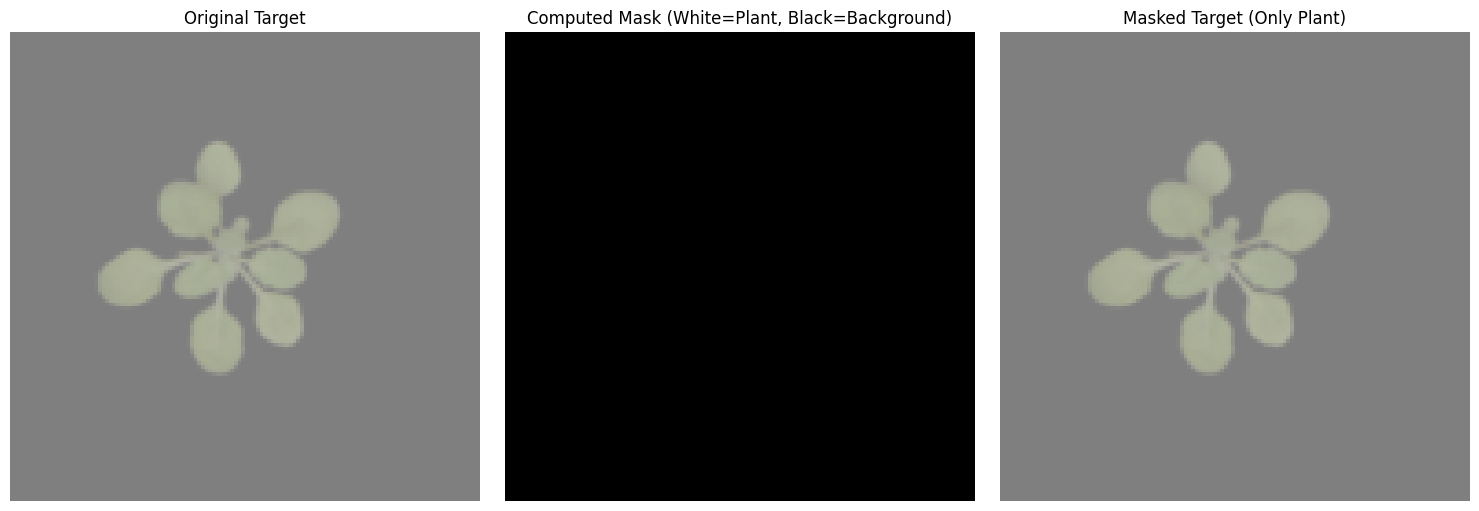

Mask coverage: 100.0% of image
Mask computation verified. Losses will only be computed on plant regions.
Checking mask stability...
Batch 0: Coverage=100.0%, Mask sum=524288
Batch 1: Coverage=100.0%, Mask sum=524288
Batch 2: Coverage=100.0%, Mask sum=524288
Batch 3: Coverage=100.0%, Mask sum=524288


In [15]:
# ============================================================================
# Define Mask Extraction Functions
# ============================================================================

def compute_mask(image, threshold=-0.9):
    """
    Compute mask for non-background regions
    Args:
        image: [B, C, H, W] tensor in range [-1, 1]
        threshold: Threshold for considering pixels as background
    Returns:
        mask: [B, 1, H, W] binary mask (1 for foreground, 0 for background)
    """
    image_mean = image.mean(dim=1, keepdim=True)
    mask = (image_mean > threshold).float()

    return mask

# ============================================================================
# Test Mask Extraction Functions
# ============================================================================
print("Verifying mask computation...")

inputs, targets, _ = next(iter(train_loader))

mask = compute_mask(targets[0:1])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original target
target_vis = ((targets[0] + 1) / 2).permute(1, 2, 0).cpu().numpy()
axes[0].imshow(np.clip(target_vis, 0, 1))
axes[0].set_title('Original Target')
axes[0].axis('off')

# Computed mask
mask_vis = mask[0, 0].cpu().numpy()
axes[1].imshow(mask_vis, cmap='gray')
axes[1].set_title('Computed Mask (White=Plant, Black=Background)')
axes[1].axis('off')

# Masked target
target_masked = (targets[0:1] * mask)[0]
target_masked_vis = ((target_masked + 1) / 2).permute(1, 2, 0).cpu().numpy()
axes[2].imshow(np.clip(target_masked_vis, 0, 1))
axes[2].set_title('Masked Target (Only Plant)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Mask coverage: {mask.mean().item()*100:.1f}% of image")
print("Mask computation verified. Losses will only be computed on plant regions.")

print("Checking mask stability...")

for i, (inputs, targets, _) in enumerate(train_loader):
    mask = compute_mask(targets)
    coverage = mask.mean().item()
    mask_sum = mask.sum().item()

    print(f"Batch {i}: Coverage={coverage*100:.1f}%, Mask sum={mask_sum:.0f}")

    if i >= 3:
        break

In [16]:
# ============================================================================
# Define Loss Functions
# ============================================================================

class PerceptualLoss(nn.Module):
    """
    Perceptual loss using VGG16
    Masks images BEFORE VGG processing (most efficient and correct)
    """
    def __init__(self, device='cuda', use_mask=TrainConfig.USE_MASK['perc']):
        super().__init__()
        vgg = models.vgg16(weights='DEFAULT').features.eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.feature_layers = [3, 8, 15, 22]
        self.vgg = vgg
        self.criterion = nn.L1Loss()
        self.use_mask = use_mask

        self.mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

    def normalize_vgg(self, x):
        x = (x + 1) / 2
        return (x - self.mean) / self.std

    def apply_mask_to_image(self, image, mask):
        """Apply mask to image before VGG"""
        if mask.shape[1] == 1:
            # Expand single channel mask to 3 channels
            mask = mask.expand_as(image)
        # Set background to ImageNet mean (better than black for VGG)
        mean_rgb = torch.tensor([0.485, 0.456, 0.406], device=image.device).view(1, 3, 1, 1)
        masked_image = image * mask + mean_rgb * (1 - mask)
        return masked_image

    def forward(self, pred, target, mask=None):
        # Apply mask to images BEFORE VGG
        if self.use_mask and mask is not None:
            pred_input = self.apply_mask_to_image(pred, mask)
            target_input = self.apply_mask_to_image(target, mask)
        else:
            pred_input = pred
            target_input = target

        # Normalize for VGG
        pred_vgg = self.normalize_vgg(pred_input)
        target_vgg = self.normalize_vgg(target_input)

        # Extract features and compute loss
        loss = 0.0
        for i, layer in enumerate(self.vgg):
            pred_vgg = layer(pred_vgg)
            target_vgg = layer(target_vgg)

            if i in self.feature_layers:
                loss += self.criterion(pred_vgg, target_vgg)

        return loss

class PSNRLoss(nn.Module):
    """Differentiable PSNR Loss with masking support"""
    def __init__(self, max_val=2.0, use_mask=TrainConfig.USE_MASK['psnr']):
        super().__init__()
        self.max_val = max_val
        self.use_mask = use_mask

    def forward(self, pred, target, mask=None):
        if self.use_mask and mask is not None:
            # Only compute MSE on masked regions
            pred_masked = pred * mask
            target_masked = target * mask
            mse = torch.sum((pred_masked - target_masked) ** 2) / (torch.sum(mask) * pred.shape[1] + 1e-10)
        else:
            mse = torch.mean((pred - target) ** 2)

        mse = torch.clamp(mse, min=1e-10)
        psnr = 20 * torch.log10(self.max_val / torch.sqrt(mse))
        return -psnr


class BackgroundRegularizationLoss(nn.Module):
    """
    Penalize non-black predictions in background regions
    Ensures background stays black
    """
    def __init__(self, target_value=-1.0):
        super().__init__()
        self.target_value = target_value  # Store as float, will convert in forward

    def forward(self, pred, mask):
        """
        Args:
            pred: [B, C, H, W] predicted image
            mask: [B, 1, H, W] binary mask (1=plant, 0=background)
        Returns:
            Loss for background region (should be black)
        """
        # Invert mask to get background regions
        background_mask = torch.ones_like(mask, device=pred.device) - mask

        # Create target value on same device as pred
        target = torch.full_like(pred, self.target_value, device=pred.device)

        # Calculate difference from target black value
        background_error = (pred - target) ** 2

        # Apply background mask and compute mean
        masked_error = background_error * background_mask
        num_background_pixels = background_mask.sum() * pred.shape[1]

        if num_background_pixels > 0:
            loss = masked_error.sum() / num_background_pixels
        else:
            loss = torch.tensor(0.0, device=pred.device)

        return loss
class ColorDifferenceLoss(nn.Module):
    """
    Direct color difference loss in masked regions
    Measures RGB difference pixel-by-pixel
    """
    def __init__(self):
        super().__init__()
        self.criterion = nn.MSELoss(reduction='none')


    def forward(self, pred, target, mask):
        """
        Args:
            pred: [B, 3, H, W] predicted RGB image in [-1, 1]
            target: [B, 3, H, W] target RGB image in [-1, 1]
            mask: [B, 1, H, W] binary mask

        Returns:
            Mean color difference in masked region
        """
        if mask is None:
            # No mask, use full image
            return self.criterion(pred, target).mean()

        # Expand mask to 3 channels
        if mask.shape[1] == 1:
            mask_3ch = mask.expand_as(pred)
        else:
            mask_3ch = mask

        # Compute color difference
        color_diff = self.criterion(pred, target)

        # Apply mask and compute mean over masked pixels
        masked_diff = color_diff * mask_3ch

        # Count masked pixels (considering all 3 channels)
        num_masked_pixels = mask_3ch.sum()

        if num_masked_pixels > 0:
            loss = masked_diff.sum() / num_masked_pixels
        else:
            # Fallback if mask is empty
            loss = color_diff.mean()

        return loss


class CombinedLoss(nn.Module):
    """Combined loss with masking and background regularization"""
    def __init__(self, l1_weight=1.0, perceptual_weight=0.1, psnr_weight=0.1,
                 background_weight=0.1, color_weight=0.5, device='cuda', use_mask={'l1':True, 'perc':True, 'psnr':True, "bg":True}):
        super().__init__()
        self.l1_weight = l1_weight
        self.perceptual_weight = perceptual_weight
        self.psnr_weight = psnr_weight
        self.background_weight = background_weight
        self.color_weight = color_weight
        self.use_mask = use_mask

        self.l1_loss = nn.L1Loss(reduction='none')
        self.perceptual_loss = PerceptualLoss(device) if perceptual_weight > 0 else None
        self.psnr_loss = PSNRLoss() if psnr_weight > 0 else None
        self.background_loss = BackgroundRegularizationLoss() if background_weight > 0 else None
        self.color_loss = ColorDifferenceLoss() if color_weight > 0 else None

    def forward(self, pred, target):

        mask = compute_mask(target)

        # L1 Loss with masking (foreground only)
        l1 = self.l1_loss(pred, target)
        if self.use_mask['l1'] and mask is not None:
            l1 = (l1 * mask).sum() / (mask.sum() * pred.shape[1] + 1e-10)
        else:
            l1 = l1.mean()

        # Perceptual Loss
        if self.perceptual_loss:
            perc = self.perceptual_loss(pred, target, mask)
        else:
            perc = torch.tensor(0.0, device=pred.device)

        # PSNR Loss with masking (foreground only)
        if self.psnr_loss:
            psnr = self.psnr_loss(pred, target, mask)
        else:
            psnr = torch.tensor(0.0, device=pred.device)

        # Background Loss (background only)
        if self.background_loss and self.use_mask['bg']:

            bg = self.background_loss(pred, mask)
        else:
            bg = torch.tensor(0.0, device=pred.device)

        # Color Difference Loss
        if self.color_loss and self.use_mask['bg']:
            color = self.color_loss(pred, target, mask)
        else:
            color = torch.tensor(0.0, device=pred.device)

        # Combined Loss
        total = (self.l1_weight * l1 +
                self.perceptual_weight * perc +
                self.psnr_weight * psnr +
                self.background_weight * bg +
                self.color_weight * color)

        return total, l1, perc, psnr, bg, color

In [17]:
# ============================================================================
# Define Training Functions
# ============================================================================

def calculate_psnr(pred, target):
    """Calculate Peak Signal-to-Noise Ratio (without masking)"""
    mse = torch.mean((pred - target) ** 2)

    if mse < 1e-10:
        return torch.tensor(100.0, device=pred.device)

    psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))
    return psnr


def train_one_epoch(model, loader, criterion, optimizer, scaler, device, epoch):
    model.train()
    total_loss, total_l1, total_psnr, total_bg, total_color = 0, 0, 0, 0, 0
    pbar = tqdm(loader, desc=f"Epoch {epoch} [Train]")

    for inputs, targets, _ in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda', enabled=scaler is not None):
            outputs = model(inputs)
            loss, l1_loss, perc_loss, psnr_loss, bg_loss, color_loss = criterion(outputs, targets)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_l1 += l1_loss.item()
        total_psnr += psnr_loss.item()
        total_bg += bg_loss.item()
        total_color += color_loss.item()

        pbar.set_postfix({
            'total loss': f'{loss.item():.4f}',
            'l1': f'{l1_loss.item():.4f}',
            'perc': f'{perc_loss.item():.4f}',
            'psnr': f'{-psnr_loss.item():.4f}',
            'bg': f'{bg_loss.item():.4f}',
            'color': f'{color_loss.item():.4f}'
        })

    return (total_loss/len(loader), total_l1/len(loader), total_psnr/len(loader), total_bg/len(loader),total_color/len(loader))


def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss, total_psnr_metric, total_bg, total_color = 0, 0, 0, 0

    with torch.no_grad():
        for inputs, targets, _ in tqdm(loader, desc=f"Epoch {epoch} [Val]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss, l1_loss, perc_loss, psnr_loss, bg_loss, color_loss = criterion(outputs, targets)
            psnr_metric = calculate_psnr(outputs, targets)

            total_loss += loss.item()
            total_psnr_metric += psnr_metric.item()
            total_bg += bg_loss.item()
            total_color += color_loss.item()

    return (total_loss/len(loader), total_psnr_metric/len(loader),total_bg/len(loader), total_color/len(loader))


def save_checkpoint(model, optimizer, scheduler, epoch, history, config, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'history': history,
    }
    save_dir = Path(config.SAVE_DIR)
    save_dir.mkdir(parents=True, exist_ok=True)

    torch.save(checkpoint, save_dir / 'checkpoint_latest.pth')
    if is_best:
        torch.save(checkpoint, save_dir / 'checkpoint_best.pth')
        print(f"Best checkpoint saved!")
    if epoch % config.SAVE_EVERY == 0:
        torch.save(checkpoint, save_dir / f'checkpoint_epoch_{epoch:03d}.pth')

print("Training functions defined!")

Training functions defined!


In [18]:
# ============================================================================
# Define Visualization Function
# ============================================================================

def denormalize(tensor):
    return (tensor + 1) / 2


def visualize_predictions(model, loader, device, epoch, save_dir, num_samples=4):
    model.eval()
    inputs, targets, plant_ids = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        predictions = model(inputs)

    # Randomly select samples from the batch
    batch_size = inputs.shape[0]
    num_samples = min(num_samples, batch_size)
    random_indices = torch.randperm(batch_size)[:num_samples]

    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, i in enumerate(random_indices):
        for j in range(5):
            img = denormalize(inputs[i,j]).permute(1,2,0).cpu().numpy()
            axes[idx,j].imshow(np.clip(img, 0, 1))
            axes[idx,j].set_title(f'Day {j+1}')
            axes[idx,j].axis('off')

        pred = denormalize(predictions[i]).permute(1,2,0).cpu().numpy()
        axes[idx,5].imshow(np.clip(pred, 0, 1))
        axes[idx,5].set_title('Predicted', color='blue')
        axes[idx,5].axis('off')

        target = denormalize(targets[i]).permute(1,2,0).cpu().numpy()
        axes[idx,6].imshow(np.clip(target, 0, 1))
        axes[idx,6].set_title('Ground Truth', color='green')
        axes[idx,6].axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=14, fontweight='bold')
    plt.tight_layout()

    save_path = Path(save_dir) / f'predictions_epoch_{epoch:03d}.png'
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


In [19]:
def train_model(model, train_loader, val_loader, config):
    device = config.DEVICE
    model = model.to(device)

    criterion = CombinedLoss(
        config.L1_WEIGHT,
        config.PERCEPTUAL_WEIGHT,
        config.PSNR_WEIGHT,
        config.BACKGROUND_WEIGHT,
        config.COLOR_WEIGHT,
        device,
        use_mask=config.USE_MASK
    )

    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=config.PATIENCE)
    scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None

    history = {'train_loss': [], 'val_loss': [], 'val_psnr': [], 'val_color': []}
    best_val_loss = float('inf')

    print(f"\n Training on {device}")
    print(f"Epochs: {config.EPOCHS} | LR: {config.LEARNING_RATE}")

    for epoch in range(1, config.EPOCHS + 1):
        print(f"\n{'='*60}\nEpoch {epoch}/{config.EPOCHS}")

        train_loss, train_l1, train_psnr, train_bg, train_color = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, epoch
        )
        val_loss, val_psnr, val_bg, val_color = validate(
            model, val_loader, criterion, device, epoch
        )

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)
        history['val_color'].append(val_color)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f}dB ")

        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss

        save_checkpoint(model, optimizer, scheduler, epoch, history, config, is_best)

        if epoch % config.VIS_EVERY == 0:
            visualize_predictions(model, val_loader, device, epoch, config.VIS_DIR, config.NUM_VIS_SAMPLES)

    print(f"\n Training complete! Best val loss: {best_val_loss:.4f}")
    return model, history

print("Main training loop defined!")

Main training loop defined!


# ConvLSTM U-Net Model Architecture

Input: [B, 5, 3, H, W]

  ↓

Encoder: CNN extracts features per frame

  ↓

ConvLSTM: Models temporal evolution

  ↓

Decoder: Generates future frame

  ↓
  
Output: [B, 3, H, W]

In [16]:
class DoubleConv(nn.Module):
    """(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handle size mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class ConvLSTMCell(nn.Module):
    """ConvLSTM cell for spatial-temporal processing"""
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2

        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,  # Gates: input, forget, output, cell
            kernel_size,
            padding=padding
        )

    def forward(self, x, hidden_state):
        h_cur, c_cur = hidden_state
        combined = torch.cat([x, h_cur], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.split(gates, self.hidden_dim, dim=1)
        i = torch.tanh(i)
        f = torch.tanh(f)
        o = torch.tanh(o)
        g = torch.tanh(g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, (h_next, c_next)


class ConvLSTMUNet(nn.Module):
    """U-Net with ConvLSTM for temporal modeling"""
    def __init__(self):
        super().__init__()

        # Encoder (per-frame)
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = Down(64, 128)
        self.enc3 = Down(128, 256)

        # ConvLSTM for temporal modeling
        self.convlstm = ConvLSTMCell(256, 256, kernel_size=3)

        # Decoder
        self.up1 = Up(256 + 256, 128, bilinear=True)  # 256 from ConvLSTM + 256 from skip
        self.up2 = Up(128 + 128, 64, bilinear=True)   # 128 from up1 + 128 from skip
        self.up3 = Up(64 + 64, 64, bilinear=True)     # 64 from up2 + 64 from skip
        self.out = nn.Conv2d(64, 3, 1)
        self.Tanh = nn.Tanh()

    def forward(self, x):
        # x: [B, T=5, C=3, H, W]
        B, T, C, H, W = x.shape

        # Encode each frame and store all features for skip connections
        all_f1, all_f2, all_f3 = [], [], []

        for t in range(T):
            frame = x[:, t]  # [B, 3, H, W]
            f1 = self.enc1(frame)      # [B, 64, H, W]
            f2 = self.enc2(f1)         # [B, 128, H/2, W/2]
            f3 = self.enc3(f2)         # [B, 256, H/4, W/4]
            all_f1.append(f1)
            all_f2.append(f2)
            all_f3.append(f3)

        # Process temporal sequence with ConvLSTM
        h_size = (B, 256, H//4, W//4)
        h = torch.zeros(h_size, device=x.device)
        c = torch.zeros(h_size, device=x.device)

        for t in range(T):
            h, (h, c) = self.convlstm(all_f3[t], (h, c))

        # Decode final hidden state to image (use skip connections from last frame)
        out = self.up1(h, all_f3[-1])   # [B, 128, H/2, W/2]
        out = self.up2(out, all_f2[-1]) # [B, 64, H, W]
        out = self.up3(out, all_f1[-1]) # [B, 64, H, W]
        out = self.out(out)             # [B, 3, H, W]

        return self.Tanh(out)

    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


print("ConvLSTM U-Net model defined!")

ConvLSTM U-Net model defined!


Loading data...
Dataset: 1040 plants, augment=True
Dataset: 92 plants, augment=False
Dataset: 92 plants, augment=False
Train: 33 batches | Val: 3 | Test: 3
Creating ConvLSTM U-Net model...
Model parameters: 6,899,331

Batch shapes: torch.Size([32, 5, 3, 128, 128]) -> torch.Size([32, 3, 128, 128])

STARTING TRAINING WITH CONVLSTM U-NET
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 244MB/s]



 Training on cuda
Epochs: 100 | LR: 2e-05

Epoch 1/100


/tmp/ipython-input-3847271205.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None


Epoch 1 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 2.0193 | Val Loss: 1.9426 | Val PSNR: 7.25dB 
Best checkpoint saved!

Epoch 2/100


Epoch 2 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.7496 | Val Loss: 1.6419 | Val PSNR: 8.62dB 
Best checkpoint saved!

Epoch 3/100


Epoch 3 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.5763 | Val Loss: 1.4797 | Val PSNR: 9.39dB 
Best checkpoint saved!

Epoch 4/100


Epoch 4 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.4484 | Val Loss: 1.3656 | Val PSNR: 10.04dB 
Best checkpoint saved!

Epoch 5/100


Epoch 5 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.3521 | Val Loss: 1.2587 | Val PSNR: 10.67dB 
Best checkpoint saved!


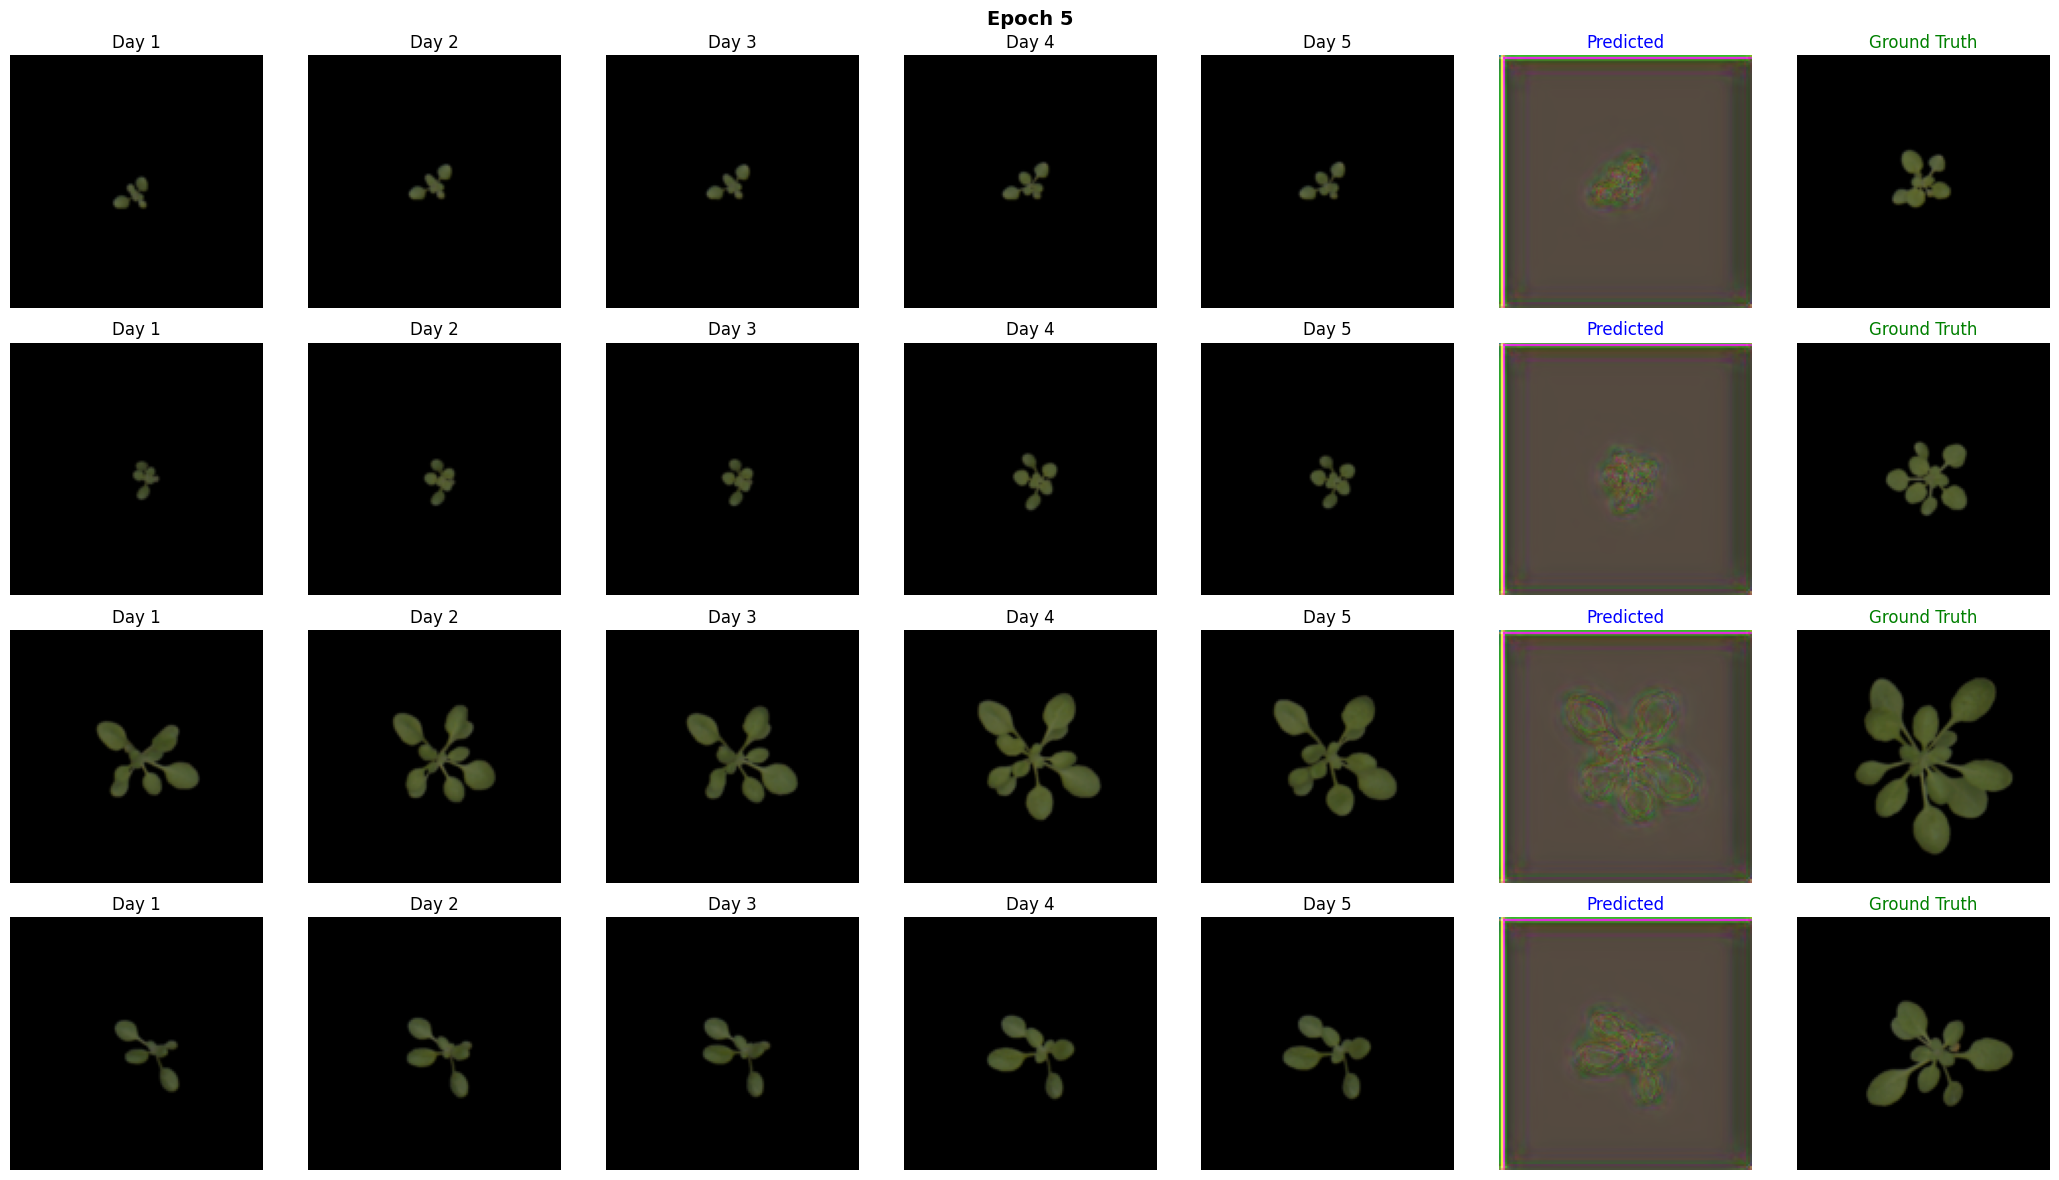


Epoch 6/100


Epoch 6 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2845 | Val Loss: 1.2043 | Val PSNR: 11.01dB 
Best checkpoint saved!

Epoch 7/100


Epoch 7 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2361 | Val Loss: 1.1621 | Val PSNR: 11.25dB 
Best checkpoint saved!

Epoch 8/100


Epoch 8 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.1974 | Val Loss: 1.1259 | Val PSNR: 11.51dB 
Best checkpoint saved!

Epoch 9/100


Epoch 9 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.1624 | Val Loss: 1.1025 | Val PSNR: 11.65dB 
Best checkpoint saved!

Epoch 10/100


Epoch 10 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.1378 | Val Loss: 1.0716 | Val PSNR: 11.86dB 
Best checkpoint saved!


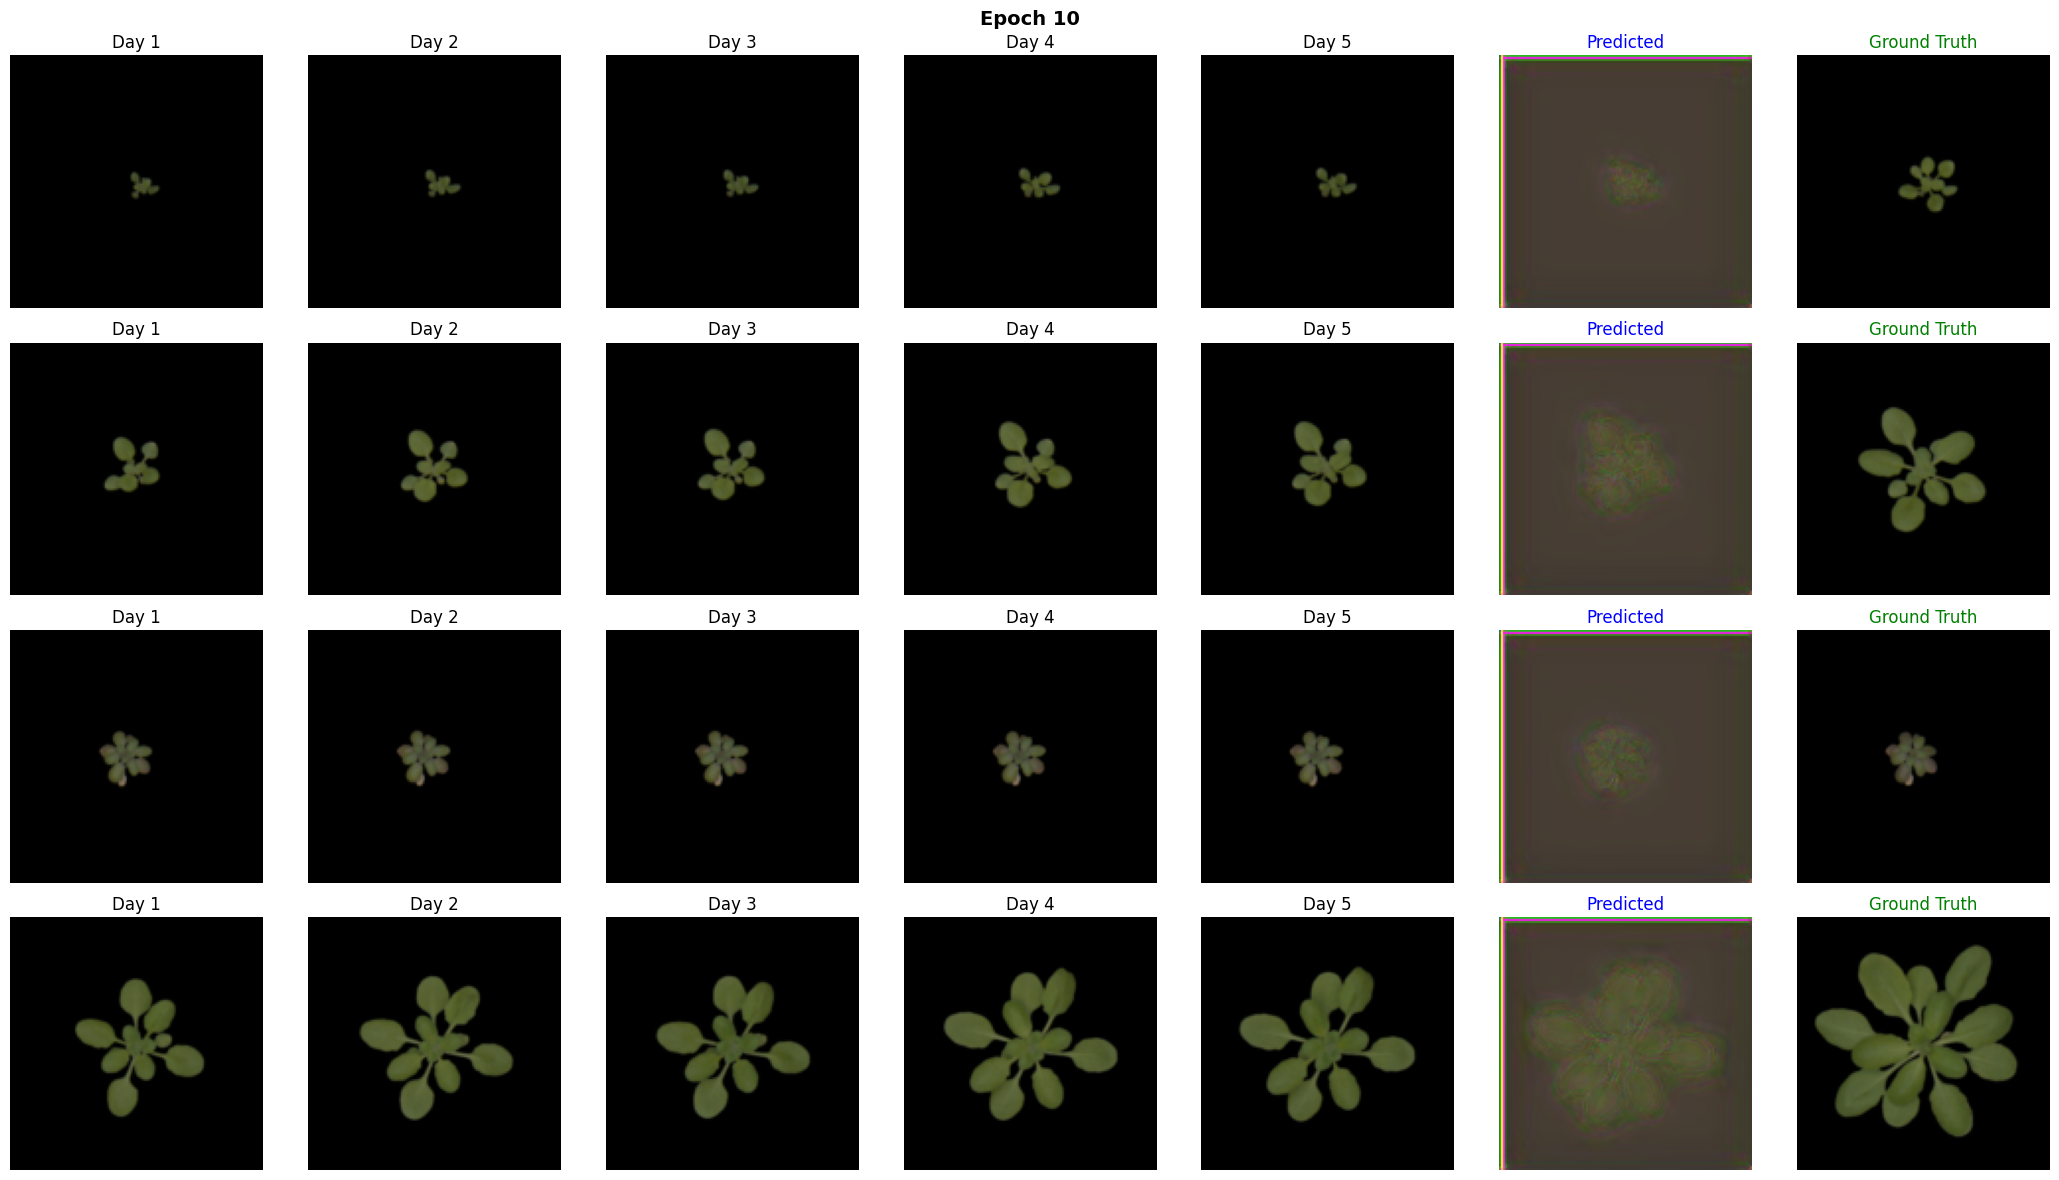


Epoch 11/100


Epoch 11 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.1117 | Val Loss: 1.0525 | Val PSNR: 12.00dB 
Best checkpoint saved!

Epoch 12/100


Epoch 12 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0863 | Val Loss: 1.0351 | Val PSNR: 12.13dB 
Best checkpoint saved!

Epoch 13/100


Epoch 13 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0738 | Val Loss: 1.0037 | Val PSNR: 12.41dB 
Best checkpoint saved!

Epoch 14/100


Epoch 14 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0394 | Val Loss: 0.9883 | Val PSNR: 12.55dB 
Best checkpoint saved!

Epoch 15/100


Epoch 15 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0189 | Val Loss: 0.9734 | Val PSNR: 12.65dB 
Best checkpoint saved!


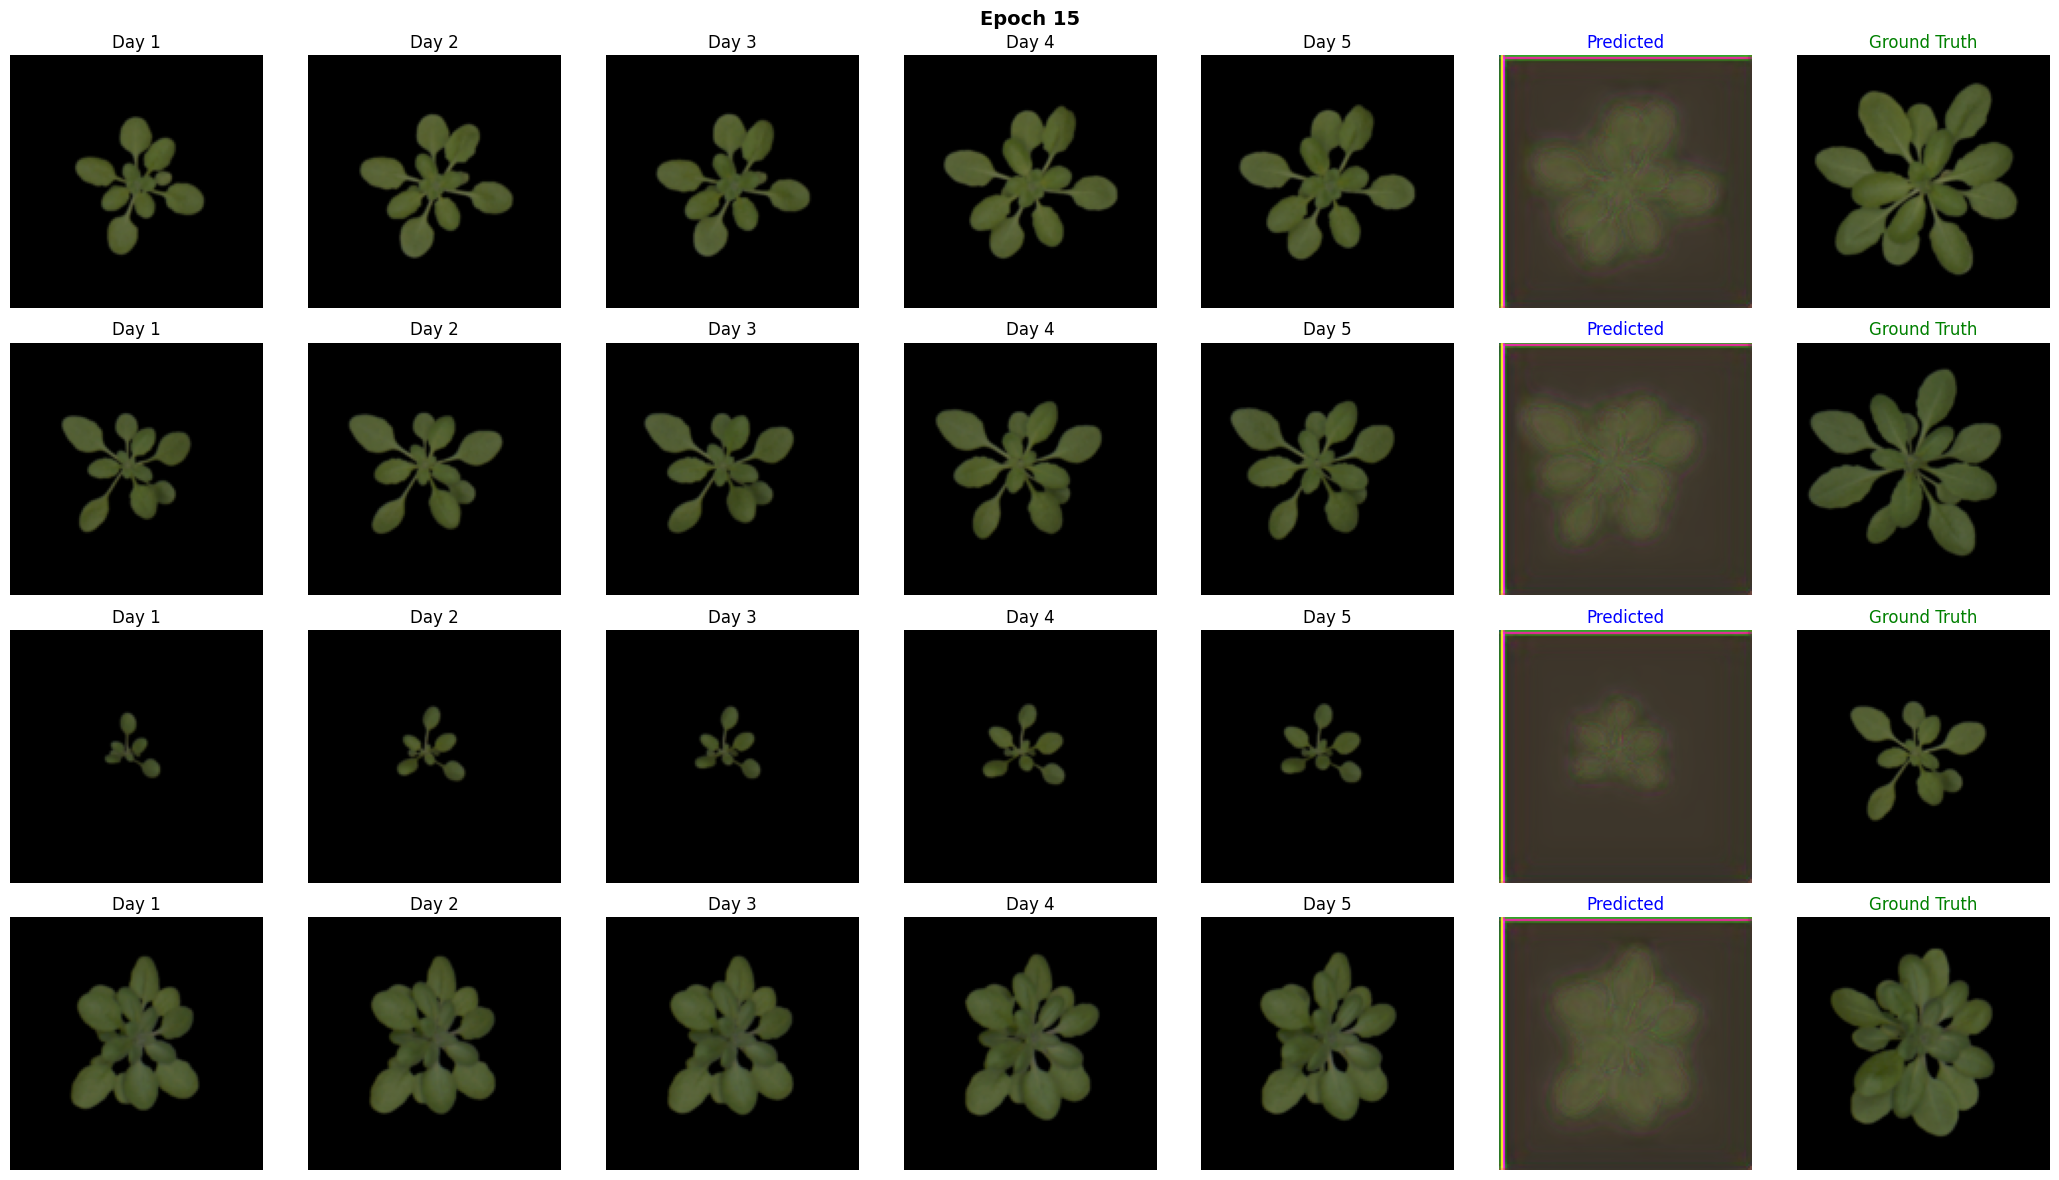


Epoch 16/100


Epoch 16 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0018 | Val Loss: 0.9666 | Val PSNR: 12.78dB 
Best checkpoint saved!

Epoch 17/100


Epoch 17 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9798 | Val Loss: 0.9380 | Val PSNR: 13.00dB 
Best checkpoint saved!

Epoch 18/100


Epoch 18 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9619 | Val Loss: 0.9249 | Val PSNR: 13.10dB 
Best checkpoint saved!

Epoch 19/100


Epoch 19 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9480 | Val Loss: 0.9131 | Val PSNR: 13.22dB 
Best checkpoint saved!

Epoch 20/100


Epoch 20 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9311 | Val Loss: 0.8864 | Val PSNR: 13.47dB 
Best checkpoint saved!


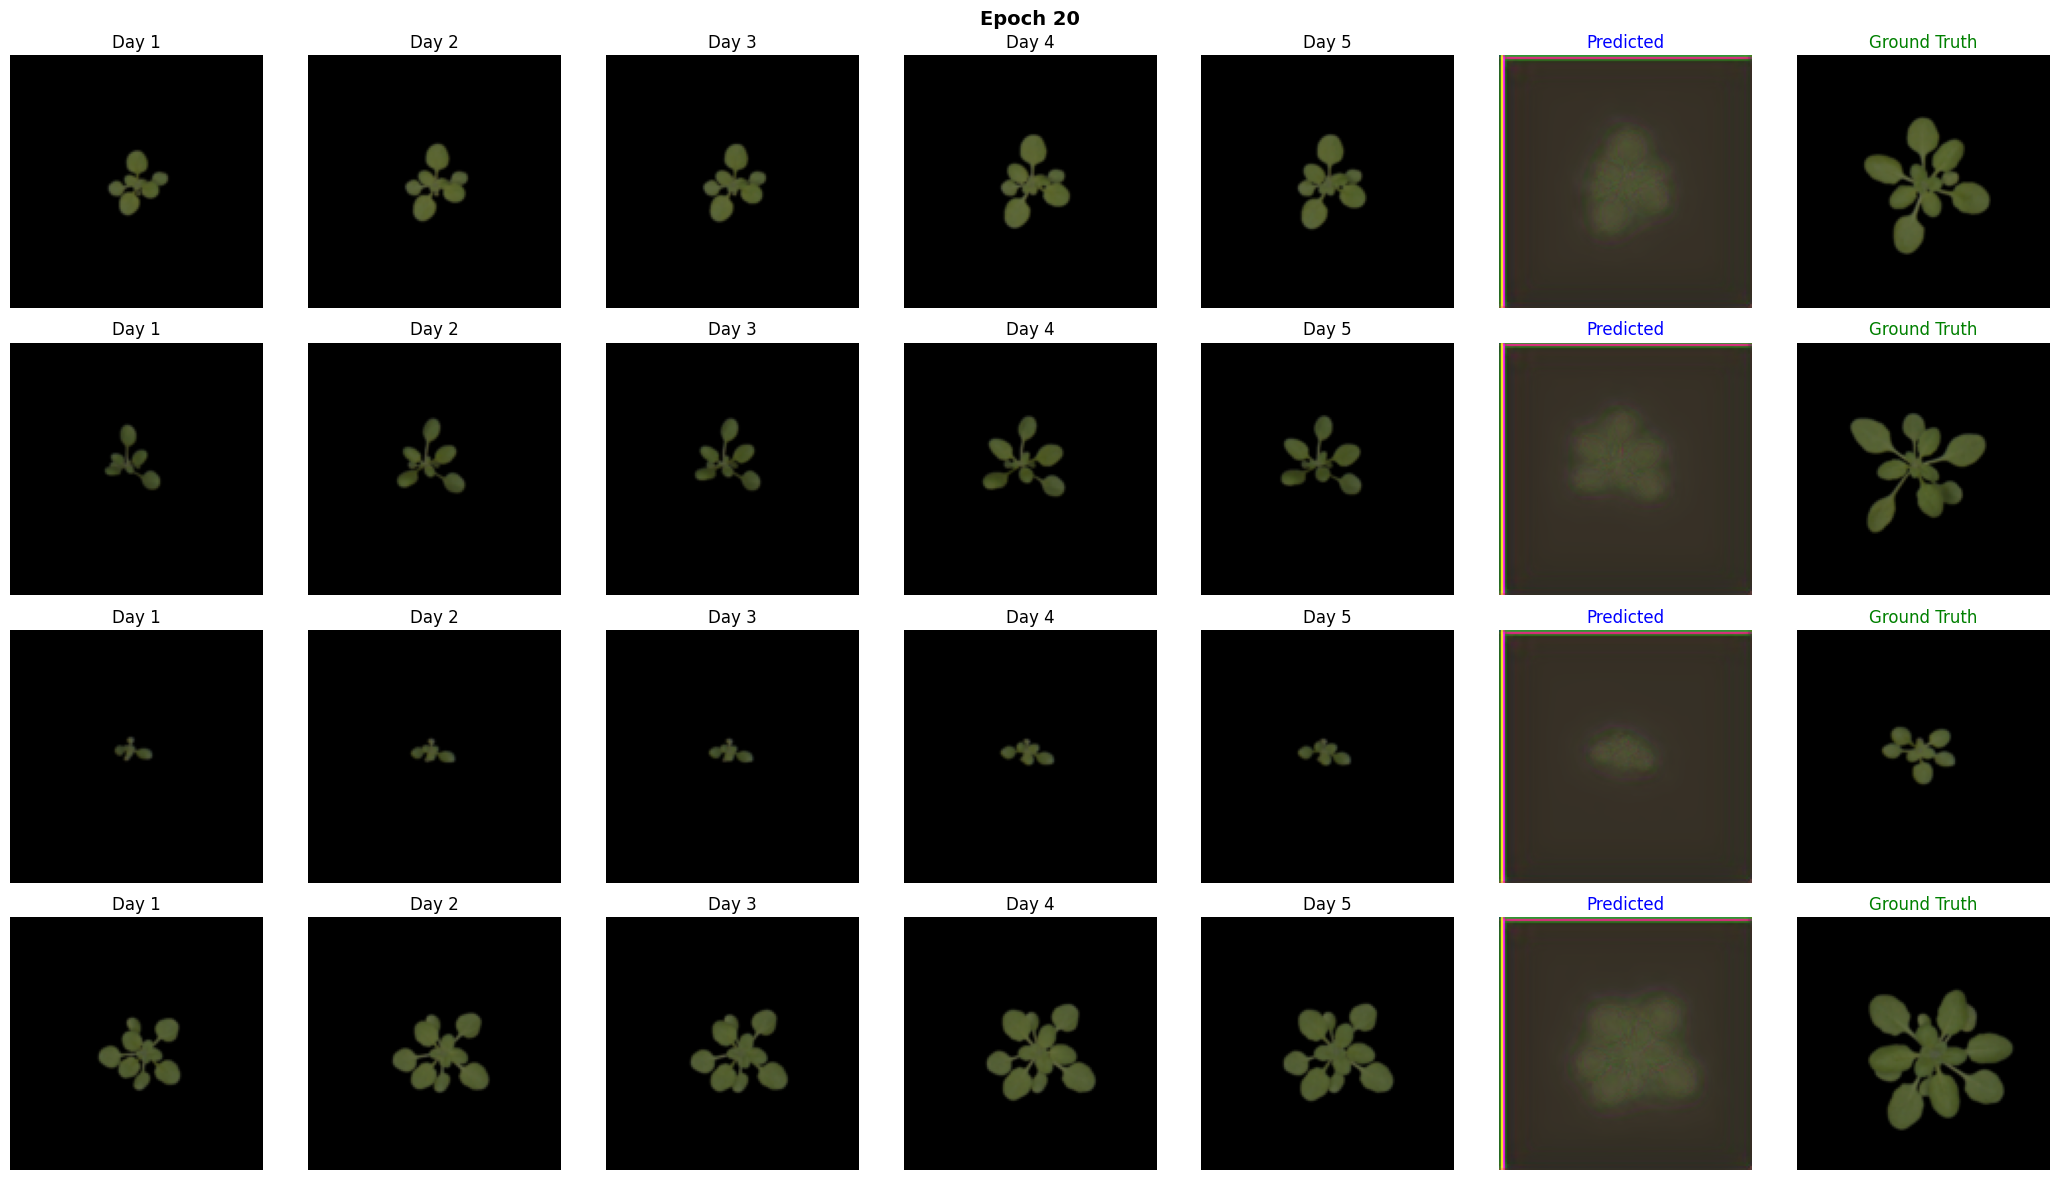


Epoch 21/100


Epoch 21 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9162 | Val Loss: 0.8782 | Val PSNR: 13.54dB 
Best checkpoint saved!

Epoch 22/100


Epoch 22 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9003 | Val Loss: 0.8762 | Val PSNR: 13.62dB 
Best checkpoint saved!

Epoch 23/100


Epoch 23 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8832 | Val Loss: 0.8414 | Val PSNR: 13.97dB 
Best checkpoint saved!

Epoch 24/100


Epoch 24 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8674 | Val Loss: 0.8340 | Val PSNR: 14.13dB 
Best checkpoint saved!

Epoch 25/100


Epoch 25 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8576 | Val Loss: 0.8262 | Val PSNR: 14.18dB 
Best checkpoint saved!


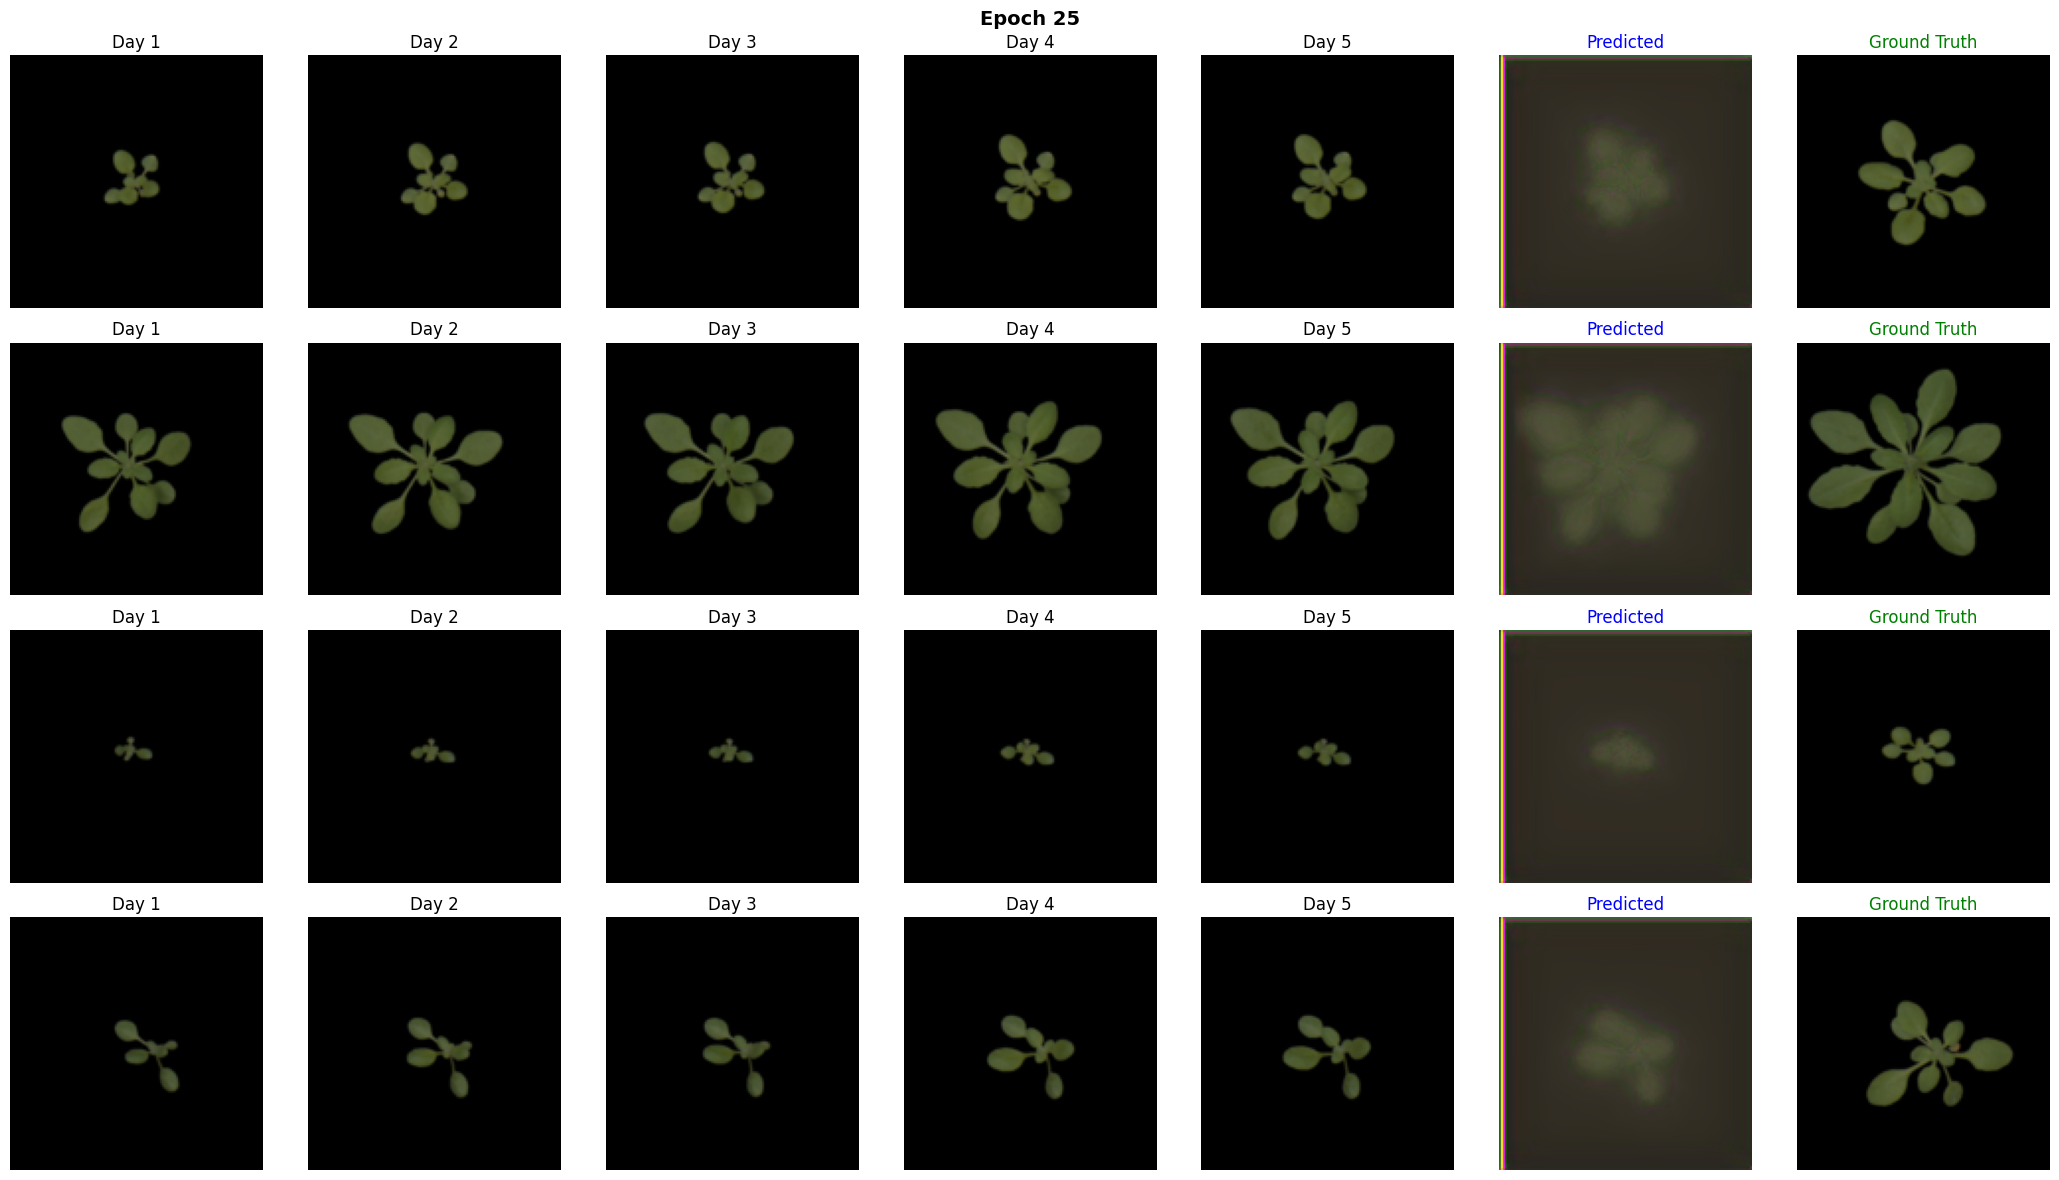


Epoch 26/100


Epoch 26 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8436 | Val Loss: 0.7902 | Val PSNR: 14.57dB 
Best checkpoint saved!

Epoch 27/100


Epoch 27 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8252 | Val Loss: 0.7998 | Val PSNR: 14.47dB 

Epoch 28/100


Epoch 28 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8132 | Val Loss: 0.7759 | Val PSNR: 14.71dB 
Best checkpoint saved!

Epoch 29/100


Epoch 29 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7938 | Val Loss: 0.7542 | Val PSNR: 14.88dB 
Best checkpoint saved!

Epoch 30/100


Epoch 30 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7810 | Val Loss: 0.7504 | Val PSNR: 14.90dB 
Best checkpoint saved!


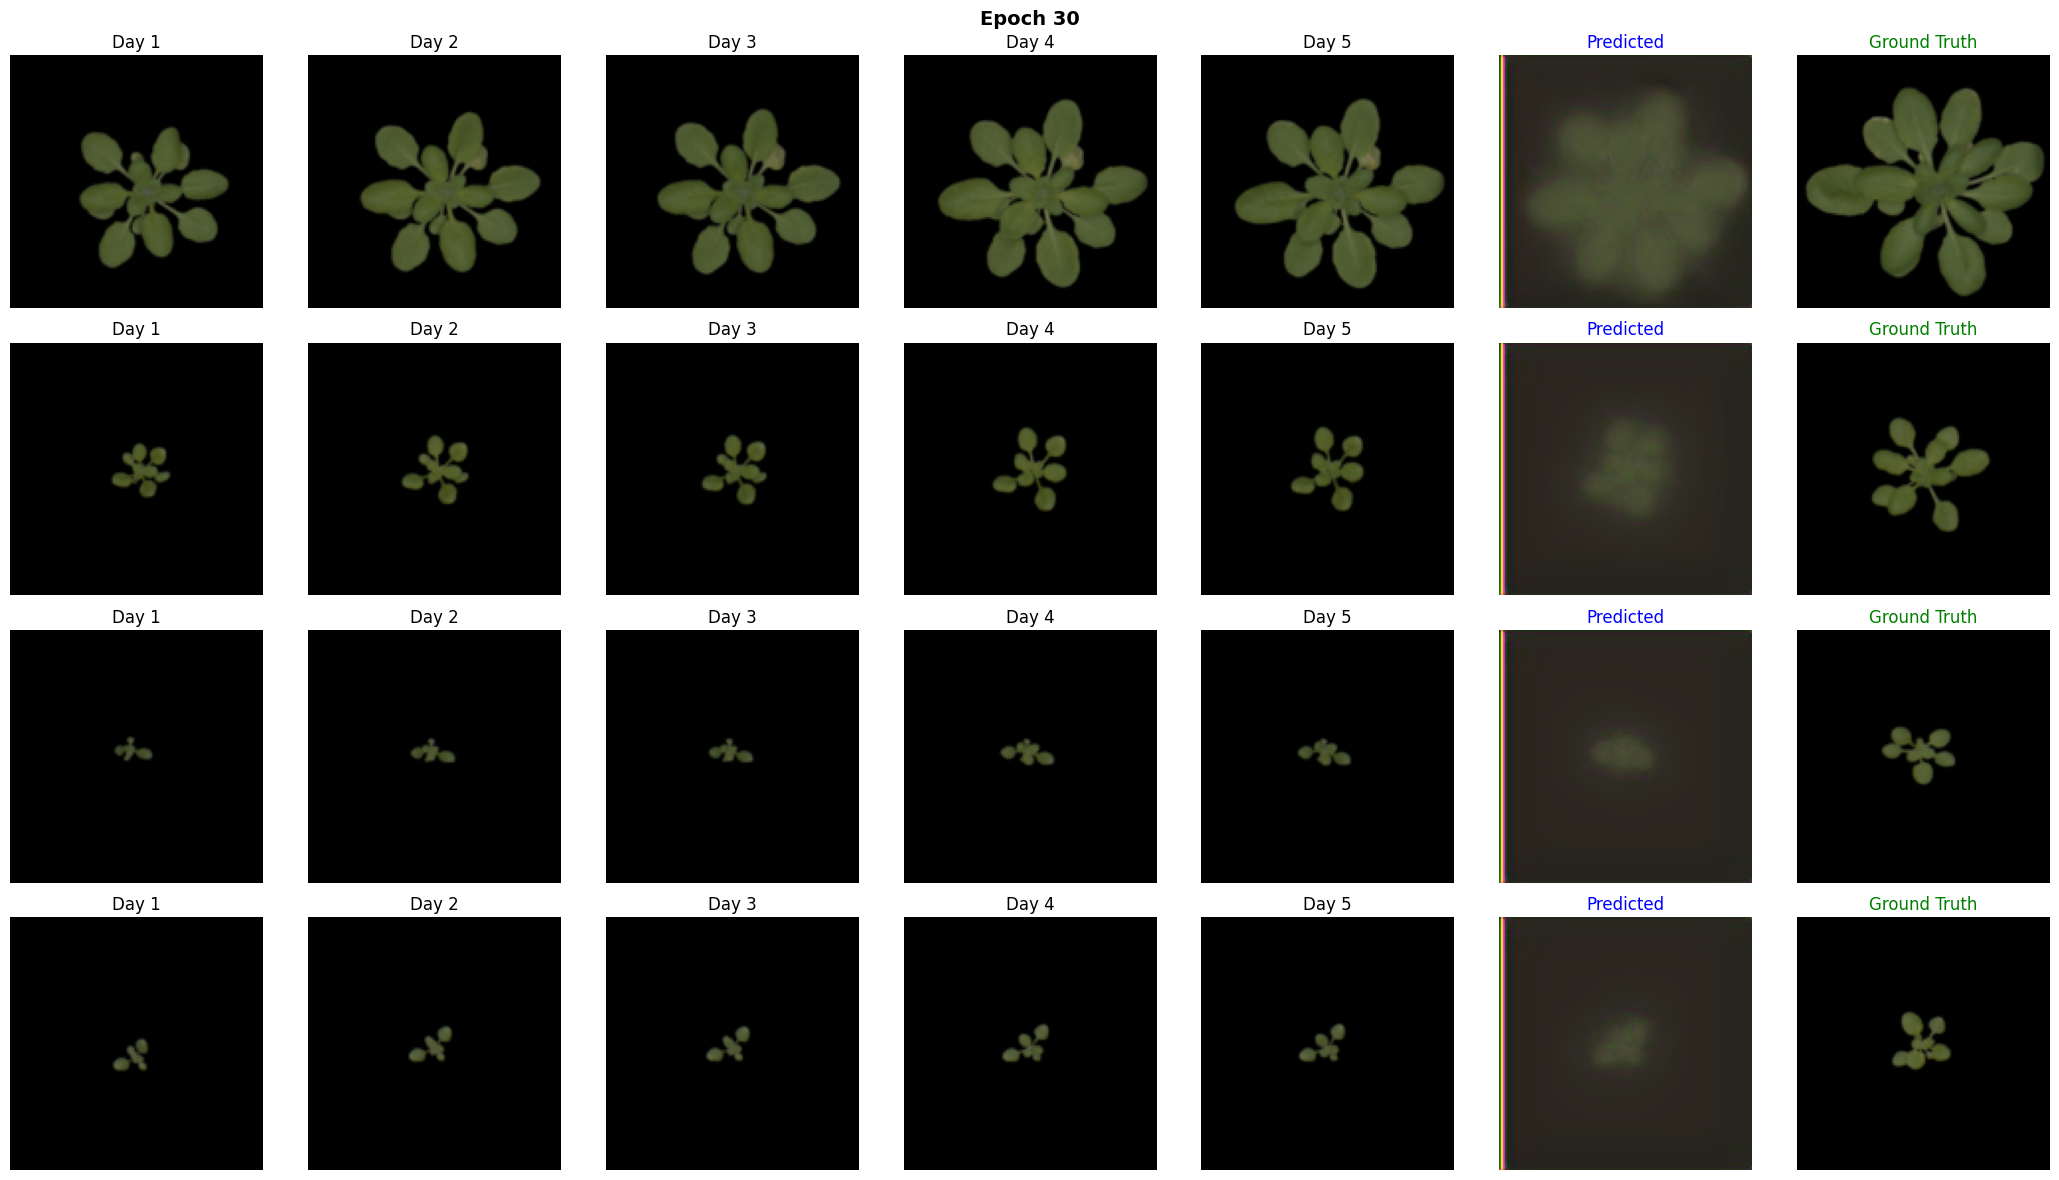


Epoch 31/100


Epoch 31 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7708 | Val Loss: 0.7429 | Val PSNR: 14.99dB 
Best checkpoint saved!

Epoch 32/100


Epoch 32 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7581 | Val Loss: 0.7229 | Val PSNR: 15.20dB 
Best checkpoint saved!

Epoch 33/100


Epoch 33 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7443 | Val Loss: 0.7215 | Val PSNR: 15.12dB 
Best checkpoint saved!

Epoch 34/100


Epoch 34 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7320 | Val Loss: 0.7257 | Val PSNR: 15.08dB 

Epoch 35/100


Epoch 35 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7226 | Val Loss: 0.6845 | Val PSNR: 15.58dB 
Best checkpoint saved!


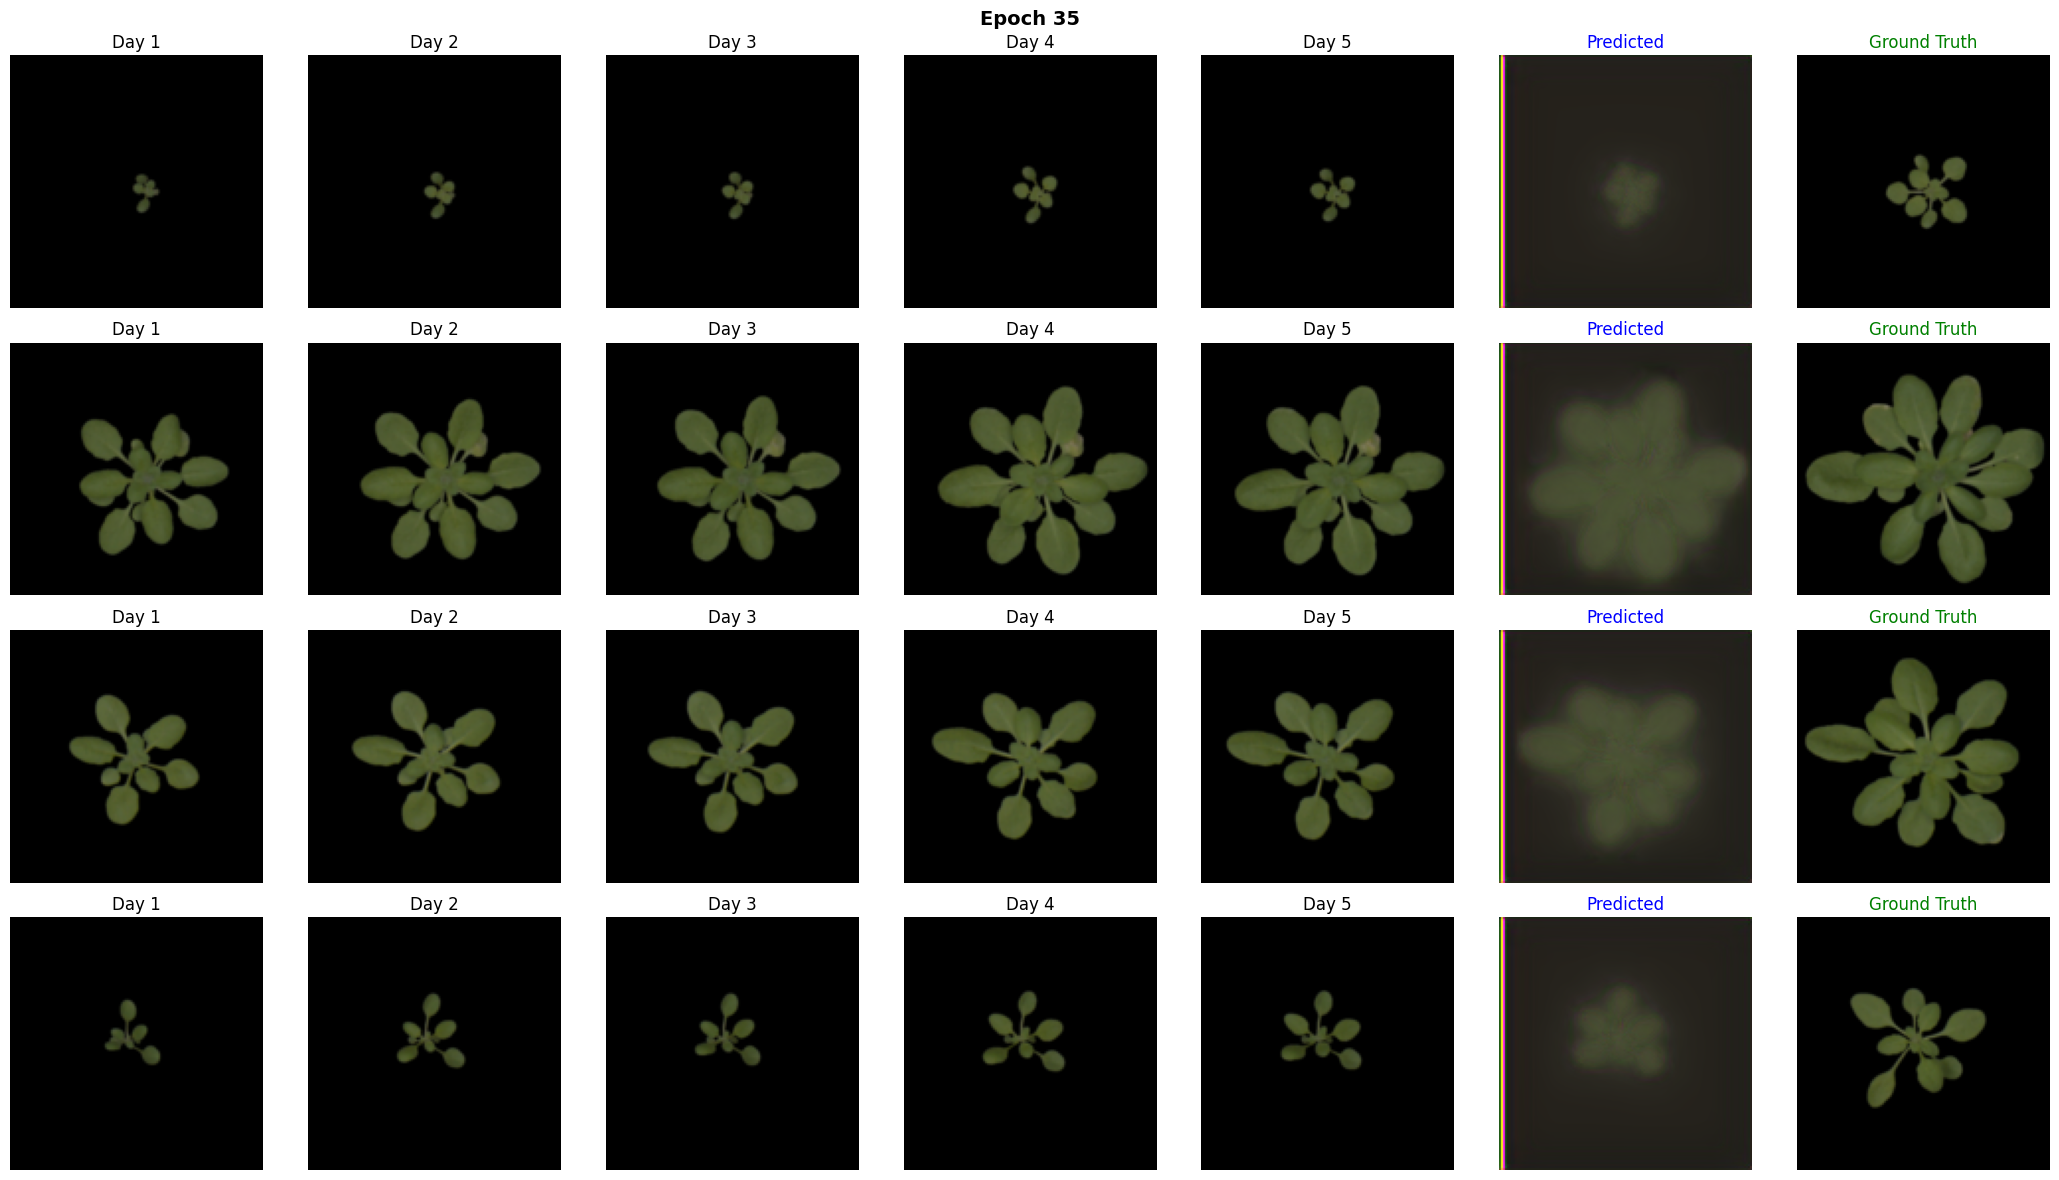


Epoch 36/100


Epoch 36 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7149 | Val Loss: 0.6771 | Val PSNR: 15.63dB 
Best checkpoint saved!

Epoch 37/100


Epoch 37 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7045 | Val Loss: 0.6714 | Val PSNR: 15.58dB 
Best checkpoint saved!

Epoch 38/100


Epoch 38 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6944 | Val Loss: 0.6556 | Val PSNR: 15.88dB 
Best checkpoint saved!

Epoch 39/100


Epoch 39 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6841 | Val Loss: 0.6431 | Val PSNR: 16.00dB 
Best checkpoint saved!

Epoch 40/100


Epoch 40 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6718 | Val Loss: 0.6484 | Val PSNR: 15.93dB 


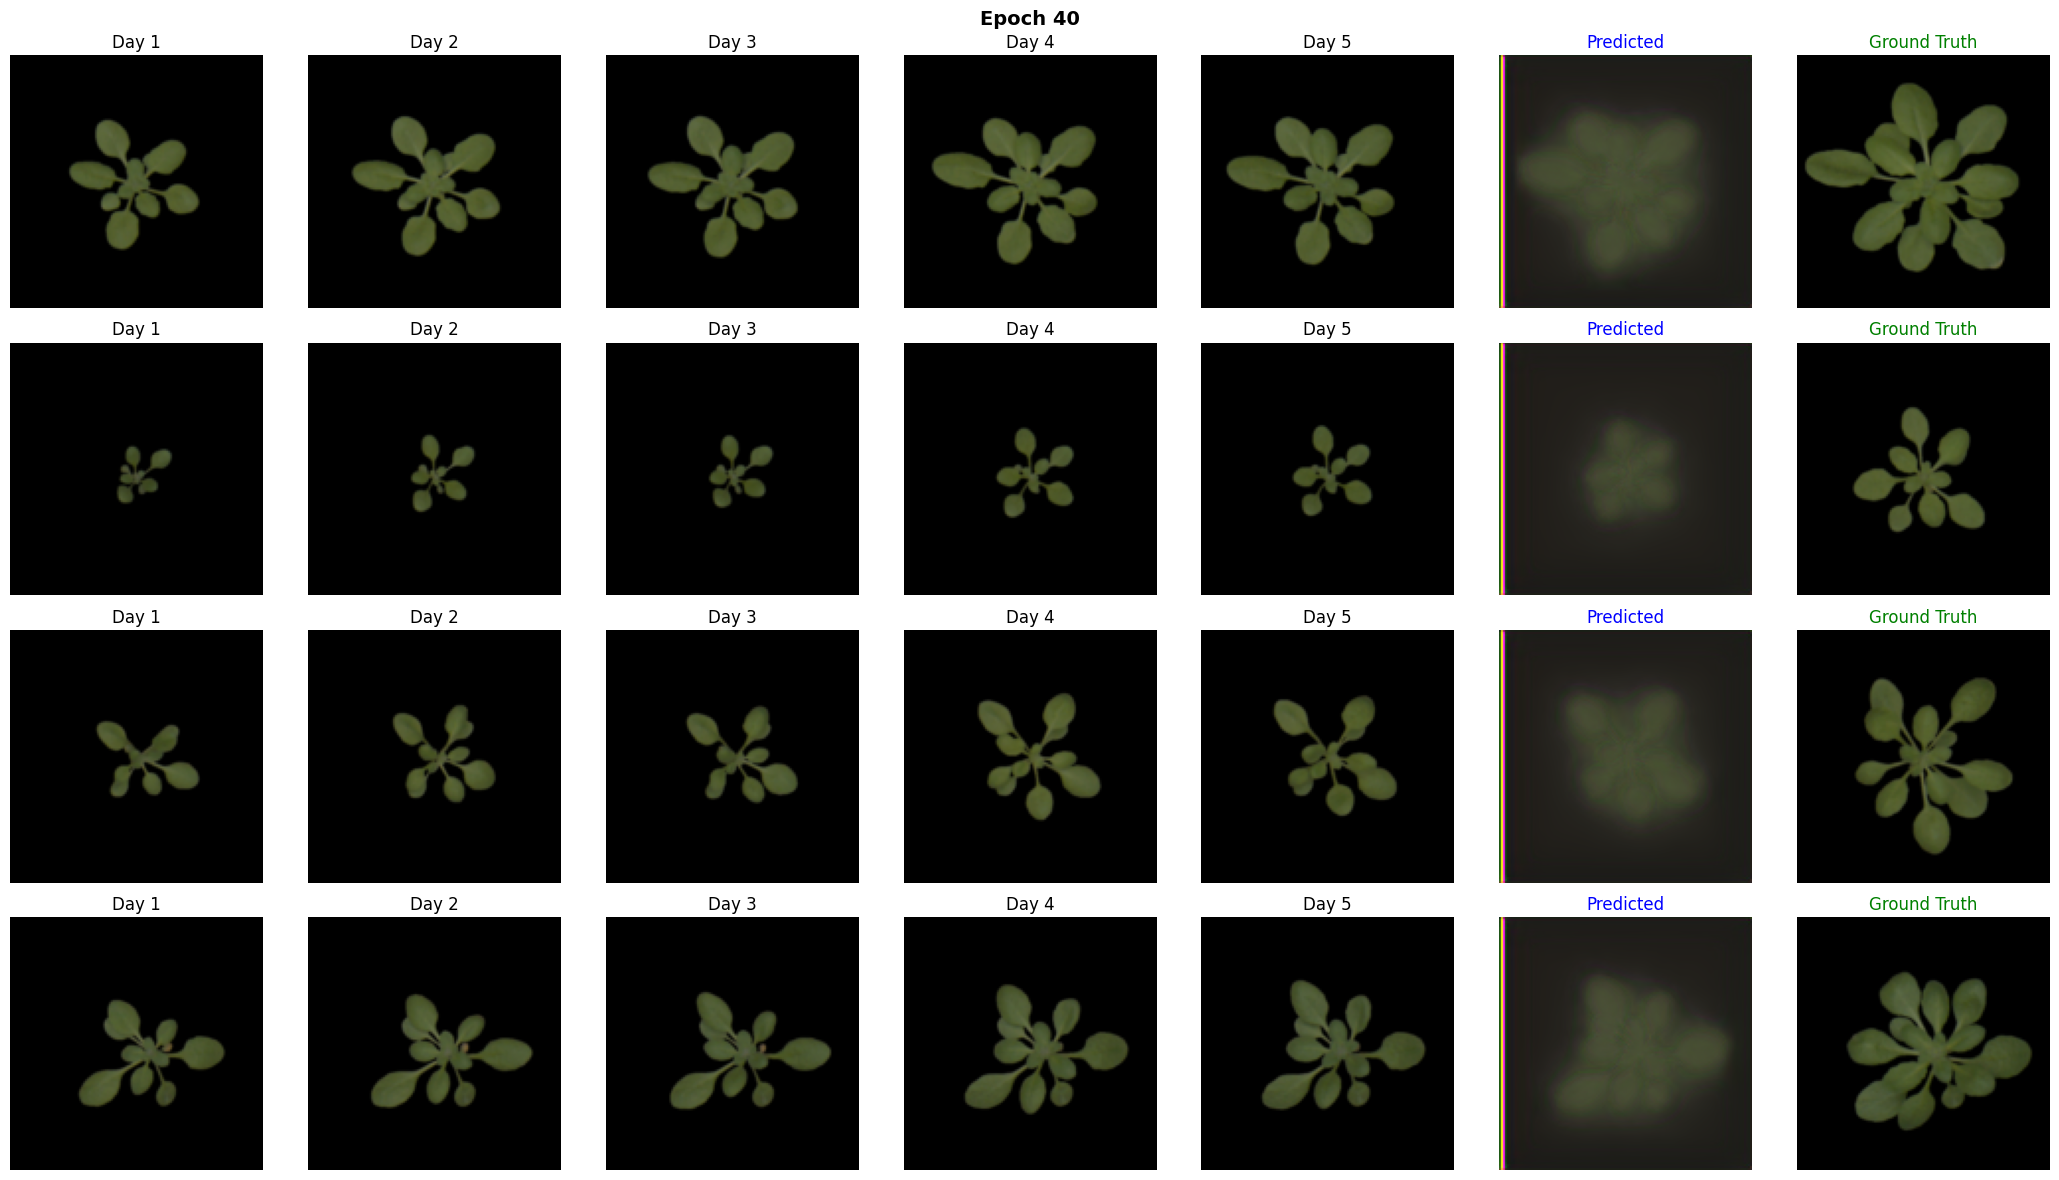


Epoch 41/100


Epoch 41 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6635 | Val Loss: 0.6440 | Val PSNR: 15.99dB 

Epoch 42/100


Epoch 42 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6531 | Val Loss: 0.6308 | Val PSNR: 16.12dB 
Best checkpoint saved!

Epoch 43/100


Epoch 43 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6457 | Val Loss: 0.6205 | Val PSNR: 16.17dB 
Best checkpoint saved!

Epoch 44/100


Epoch 44 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6371 | Val Loss: 0.6108 | Val PSNR: 16.31dB 
Best checkpoint saved!

Epoch 45/100


Epoch 45 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6285 | Val Loss: 0.6085 | Val PSNR: 16.34dB 
Best checkpoint saved!


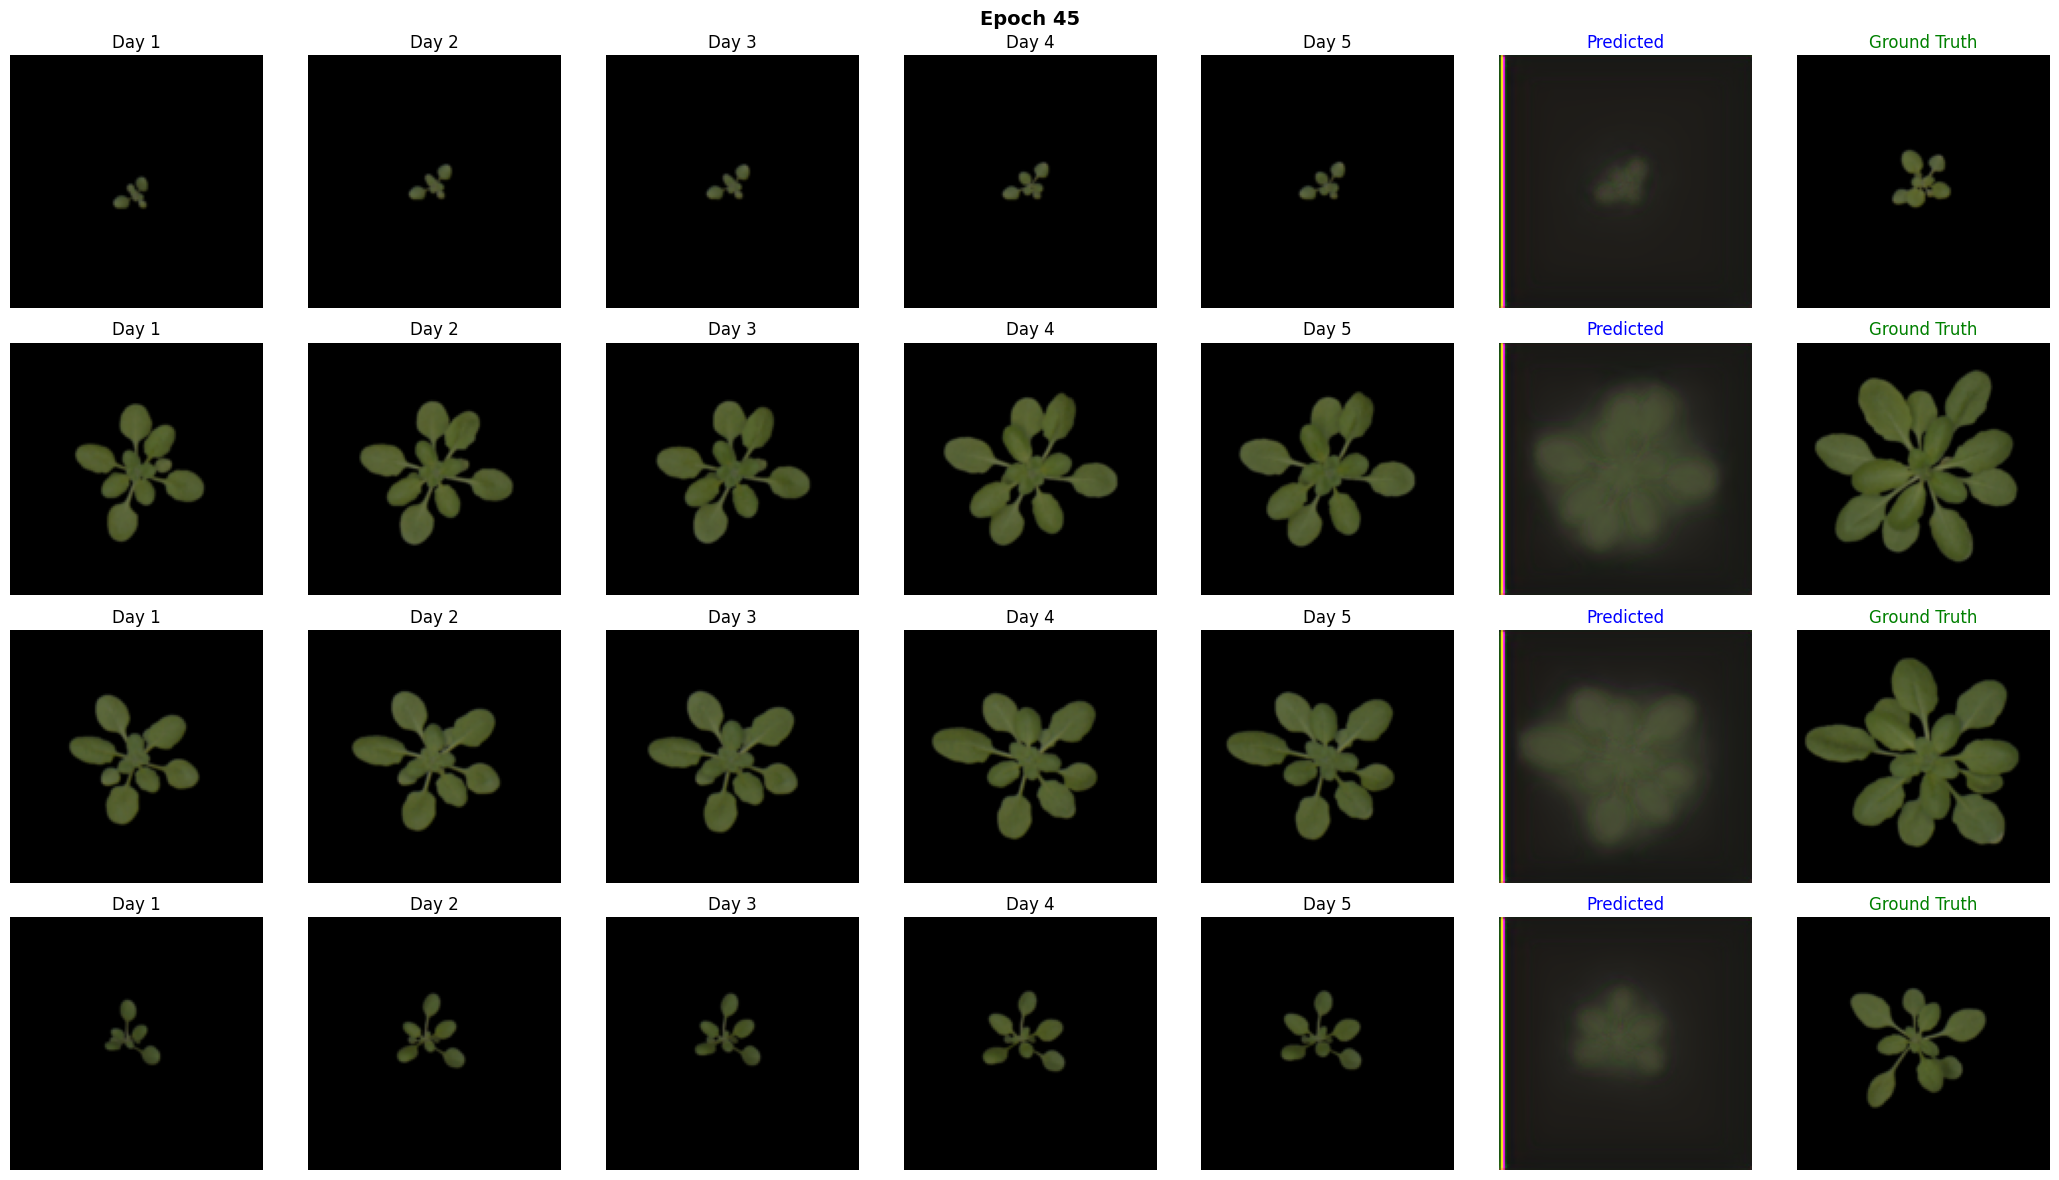


Epoch 46/100


Epoch 46 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
train_config = TrainConfig()

# Create dataloaders
print("Loading data...")
train_loader, val_loader, test_loader = create_dataloaders(data_config)

# Create ConvLSTM U-Net model
print("Creating ConvLSTM U-Net model...")
model = ConvLSTMUNet()
total_params, _ = model.count_parameters()
print(f"Model parameters: {total_params:,}")

# Visualize one batch
inputs, targets, ids = next(iter(train_loader))
print(f"\nBatch shapes: {inputs.shape} -> {targets.shape}")

# START TRAINING
print("\n" + "="*80)
print("STARTING TRAINING WITH CONVLSTM U-NET")
print("="*80)

trained_model, history = train_model(model, train_loader, val_loader, train_config)

print("ALL DONE!")

# 3D U-Net Architecture

In [ ]:
class DoubleConv3D(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down3D(nn.Module):
    """Downscaling with maxpool3d then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Only downsample spatially (H, W), keep temporal dimension
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),  # (T, H, W)
            DoubleConv3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up3D(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            # Use trilinear interpolation for 3D
            self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, in_channels // 2)
        else:
            # Transposed convolution - only upsample spatially
            self.up = nn.ConvTranspose3d(
                in_channels, in_channels // 2,
                kernel_size=(1, 2, 2),
                stride=(1, 2, 2)
            )
            self.conv = DoubleConv3D(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Handle size mismatch (T, H, W)
        diffT = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2,
            diffT // 2, diffT - diffT // 2
        ])

        # Concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet3D(nn.Module):
    """
    3D U-Net for temporal plant growth prediction

    Input: [B, 5, 3, H, W] - 5 consecutive plant images
    Output: [B, 3, H, W] - Predicted future plant image

    Architecture:
    - Processes spatial and temporal dimensions together
    - 3D convolutions on (T, H, W)
    - Encoder-decoder with skip connections
    """

    def __init__(self, n_frames=5, input_channels=3, output_channels=3, bilinear=True):
        super().__init__()
        self.n_frames = n_frames
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.bilinear = bilinear

        # Initial convolution
        self.inc = DoubleConv3D(input_channels, 64)

        # Encoder (downsampling spatially, keeping temporal dimension)
        self.down1 = Down3D(64, 128)
        self.down2 = Down3D(128, 256)
        self.down3 = Down3D(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down3D(512, 1024 // factor)

        # Decoder (upsampling spatially)
        self.up1 = Up3D(1024, 512 // factor, bilinear)
        self.up2 = Up3D(512, 256 // factor, bilinear)
        self.up3 = Up3D(256, 128 // factor, bilinear)
        self.up4 = Up3D(128, 64, bilinear)

        # Final output layer - reduce temporal dimension to 1
        self.outc = nn.Conv3d(64, output_channels, kernel_size=(n_frames, 1, 1))

        # Output activation
        self.output_activation = nn.Tanh()

    def forward(self, x):
        """
        Args:
            x: [B, 5, 3, H, W] - Input sequence

        Returns:
            [B, 3, H, W] - Predicted image
        """
        # Reshape: [B, T=5, C=3, H, W] → [B, C=3, T=5, H, W]
        B, T, C, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4)  # [B, 3, 5, H, W]

        # Encoder with skip connections
        x1 = self.inc(x)      # [B, 64, 5, H, W]
        x2 = self.down1(x1)   # [B, 128, 5, H/2, W/2]
        x3 = self.down2(x2)   # [B, 256, 5, H/4, W/4]
        x4 = self.down3(x3)   # [B, 512, 5, H/8, W/8]
        x5 = self.down4(x4)   # [B, 512, 5, H/16, W/16]

        # Decoder with skip connections
        x = self.up1(x5, x4)  # [B, 512, 5, H/8, W/8]
        x = self.up2(x, x3)   # [B, 256, 5, H/4, W/4]
        x = self.up3(x, x2)   # [B, 128, 5, H/2, W/2]
        x = self.up4(x, x1)   # [B, 64, 5, H, W]

        # Final convolution to reduce temporal dimension
        logits = self.outc(x)  # [B, 3, 1, H, W]

        # Remove temporal dimension
        logits = logits.squeeze(2)  # [B, 3, H, W]

        # Apply activation
        output = self.output_activation(logits)

        return output

    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


def test_unet3d():
    """Test the 3D U-Net model"""
    print("=" * 80)
    print("Testing 3D U-Net Model")
    print("=" * 80)

    # Create model
    model = UNet3D(n_frames=5, input_channels=3, output_channels=3, bilinear=True)

    # Count parameters
    total_params, trainable_params = model.count_parameters()
    print(f" Model Parameters:")
    print(f"   - Total: {total_params:,}")
    print(f"   - Trainable: {trainable_params:,}")
    print(f"   - Size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

    # Test forward pass
    batch_size = 2
    input_tensor = torch.randn(batch_size, 5, 3, 256, 256)

    print(f"Testing forward pass...")
    print(f"   - Input shape: {input_tensor.shape}")

    with torch.no_grad():
        output = model(input_tensor)

    print(f"   - Output shape: {output.shape}")
    print(f"   - Output range: [{output.min():.3f}, {output.max():.3f}]")

    assert output.shape == (batch_size, 3, 256, 256), "Output shape mismatch!"

    print(f"3D U-Net test passed!")
    print("=" * 80)

    return model


print("3D U-Net model defined!")

# Uncomment to test:
# test_unet3d()

In [ ]:

train_config = TrainConfig()

# Create dataloaders
print("Loading data...")
train_loader, val_loader, test_loader = create_dataloaders(data_config)

# Create 3D U-Net model
print("Creating 3D U-Net model...")
model = UNet3D(n_frames=5, input_channels=3, output_channels=3, bilinear=True)
total_params, _ = model.count_parameters()
print(f"Model parameters: {total_params:,}")

# Visualize one batch
inputs, targets, ids = next(iter(train_loader))
print(f"\nBatch shapes: {inputs.shape} -> {targets.shape}")

# START TRAINING
print("\n" + "="*80)
print("STARTING TRAINING WITH 3D U-NET")
print("="*80)

trained_model, history = train_model(model, train_loader, val_loader, train_config)

print("ALL DONE!")

# CNN-Transformer

In [ ]:

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# CNN Encoder - Extracts spatial features from each frame
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, output_dim=512):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(base_channels, base_channels * 2, 2)
        self.layer2 = self._make_layer(base_channels * 2, base_channels * 4, 2)
        self.layer3 = self._make_layer(base_channels * 4, base_channels * 8, 2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 8, output_dim)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x


# Transformer Encoder - Models temporal dependencies
class TransformerEncoder(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_layers=4, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, max_len=10, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x


# Temporal Aggregation - Combines frame information
class TemporalAggregation(nn.Module):
    def __init__(self, d_model=512):
        super().__init__()
        self.attention_query = nn.Parameter(torch.randn(1, 1, d_model))
        self.attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

    def forward(self, x):
        B = x.shape[0]
        query = self.attention_query.expand(B, -1, -1)
        aggregated, _ = self.attention(query, x, x)
        return aggregated.squeeze(1)


# CNN Decoder - Generates output image
class CNNDecoder(nn.Module):
    def __init__(self, input_dim=512, output_channels=3, img_size=128):
        super().__init__()
        self.img_size = img_size
        self.init_size = img_size // 32

        self.fc = nn.Linear(input_dim, 512 * self.init_size * self.init_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.output_conv = nn.Sequential(
            nn.Conv2d(16, output_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, self.init_size, self.init_size)
        x = self.decoder(x)
        x = self.output_conv(x)
        return x


# Complete CNN-Transformer Model
class CNNTransformerPlantPredictor(nn.Module):
    """
    CNN-Transformer for Plant Growth Prediction

    Input: [B, 5, 3, H, W] - 5 frames of plant growth
    Output: [B, 3, H, W] - Predicted day 10 image
    """
    def __init__(self, n_frames=5, input_channels=3, output_channels=3, img_size=128,
                 encoder_dim=512, transformer_heads=8, transformer_layers=4, dropout=0.1):
        super().__init__()

        self.n_frames = n_frames
        self.encoder_dim = encoder_dim

        self.cnn_encoder = CNNEncoder(
            in_channels=input_channels,
            base_channels=64,
            output_dim=encoder_dim
        )

        self.transformer = TransformerEncoder(
            d_model=encoder_dim,
            nhead=transformer_heads,
            num_layers=transformer_layers,
            dim_feedforward=encoder_dim * 4,
            dropout=dropout
        )

        self.temporal_aggregation = TemporalAggregation(d_model=encoder_dim)

        self.cnn_decoder = CNNDecoder(
            input_dim=encoder_dim,
            output_channels=output_channels,
            img_size=img_size
        )

    def forward(self, x):
        """
        Args:
            x: [B, T, C, H, W] - Input sequence
        Returns:
            [B, C, H, W] - Predicted image
        """
        B, T, C, H, W = x.shape

        # Encode each frame
        x_flat = x.view(B * T, C, H, W)
        encoded = self.cnn_encoder(x_flat)
        encoded = encoded.view(B, T, self.encoder_dim)

        # Transformer for temporal modeling
        temporal_features = self.transformer(encoded)

        # Aggregate temporal information
        aggregated = self.temporal_aggregation(temporal_features)

        # Decode to output image
        output = self.cnn_decoder(aggregated)

        return output

    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


def test_model():
    print("=" * 80)
    print("🧪 Testing CNN-Transformer Model")
    print("=" * 80)

    model = CNNTransformerPlantPredictor(
        n_frames=5,
        input_channels=3,
        output_channels=3,
        img_size=128,
        encoder_dim=512,
        transformer_heads=8,
        transformer_layers=4
    )

    total_params, trainable_params = model.count_parameters()
    print(f"\n📊 Model Parameters:")
    print(f"   Total: {total_params:,}")
    print(f"   Trainable: {trainable_params:,}")
    print(f"   Size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

    test_input = torch.randn(2, 5, 3, 128, 128)
    print(f"\n🔍 Forward Pass:")
    print(f"   Input:  {test_input.shape}")

    with torch.no_grad():
        output = model(test_input)

    print(f"   Output: {output.shape}")
    print(f"   Range:  [{output.min():.3f}, {output.max():.3f}]")

    assert output.shape == (2, 3, 128, 128), "Shape mismatch!"
    print(f"\n✅ Test passed!")
    print("=" * 80)

    return model

print("CNN-Transformer model defined!")

In [ ]:
train_config = TrainConfig()

# Create dataloaders
print("Loading data...")
train_loader, val_loader, test_loader = create_dataloaders(data_config)

# Create 3D U-Net model
print("Creating CNN-Transformer model...")
model = CNNTransformerPlantPredictor(
    n_frames=5,                    # Number of input frames
    input_channels=3,              # RGB channels
    output_channels=3,             # RGB output
    img_size=128,                  # Your image size (adjust if different)
    encoder_dim=512,               # Feature dimension (512 or 256)
    transformer_heads=8,           # Number of attention heads
    transformer_layers=4,          # Number of transformer layers
    dropout=0.1                    # Dropout rate
).to(TrainConfig.DEVICE)

# Count parameters
total_params, trainable_params = model.count_parameters()
print(f"\n🎯 CNN-Transformer Model Initialized")
print(f"   - Total parameters: {total_params:,}")

# Visualize one batch
inputs, targets, ids = next(iter(train_loader))
print(f"\nBatch shapes: {inputs.shape} -> {targets.shape}")

# START TRAINING
print("\n" + "="*80)
print("STARTING TRAINING WITH CNN-Transformer")
print("="*80)

trained_model, history = train_model(model, train_loader, val_loader, train_config)

print("ALL DONE!")


# 2D U-Net Architecture

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, 2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """U-Net for temporal plant growth prediction"""

    def __init__(self, n_channels=15, n_classes=3, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // (2 if bilinear else 1))

        self.up1 = Up(1024, 512 // (2 if bilinear else 1), bilinear)
        self.up2 = Up(512, 256 // (2 if bilinear else 1), bilinear)
        self.up3 = Up(256, 128 // (2 if bilinear else 1), bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        # Reshape: [B, 5, 3, H, W] -> [B, 15, H, W]
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)

        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output
        logits = self.outc(x)
        return self.output_activation(logits)

    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable

print("U-Net model defined!")

U-Net model defined!



 Loading data...
Dataset: 1040 plants, augment=True
Dataset: 92 plants, augment=False
Dataset: 92 plants, augment=False
Train: 33 batches | Val: 3 | Test: 3

 Creating model...
Model parameters: 13,398,403

Batch shapes: torch.Size([32, 5, 3, 128, 128]) -> torch.Size([32, 3, 128, 128])

STARTING TRAINING

 Training on cuda
Epochs: 100 | LR: 2e-05

Epoch 1/100


/tmp/ipython-input-3847271205.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None


Epoch 1 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.9743 | Val Loss: 1.9208 | Val PSNR: 2.97dB 
Best checkpoint saved!

Epoch 2/100


Epoch 2 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.9086 | Val Loss: 1.8906 | Val PSNR: 3.10dB 
Best checkpoint saved!

Epoch 3/100


Epoch 3 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8656 | Val Loss: 1.8904 | Val PSNR: 3.15dB 
Best checkpoint saved!

Epoch 4/100


Epoch 4 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8412 | Val Loss: 1.8504 | Val PSNR: 3.25dB 
Best checkpoint saved!

Epoch 5/100


Epoch 5 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8210 | Val Loss: 1.8026 | Val PSNR: 3.39dB 
Best checkpoint saved!


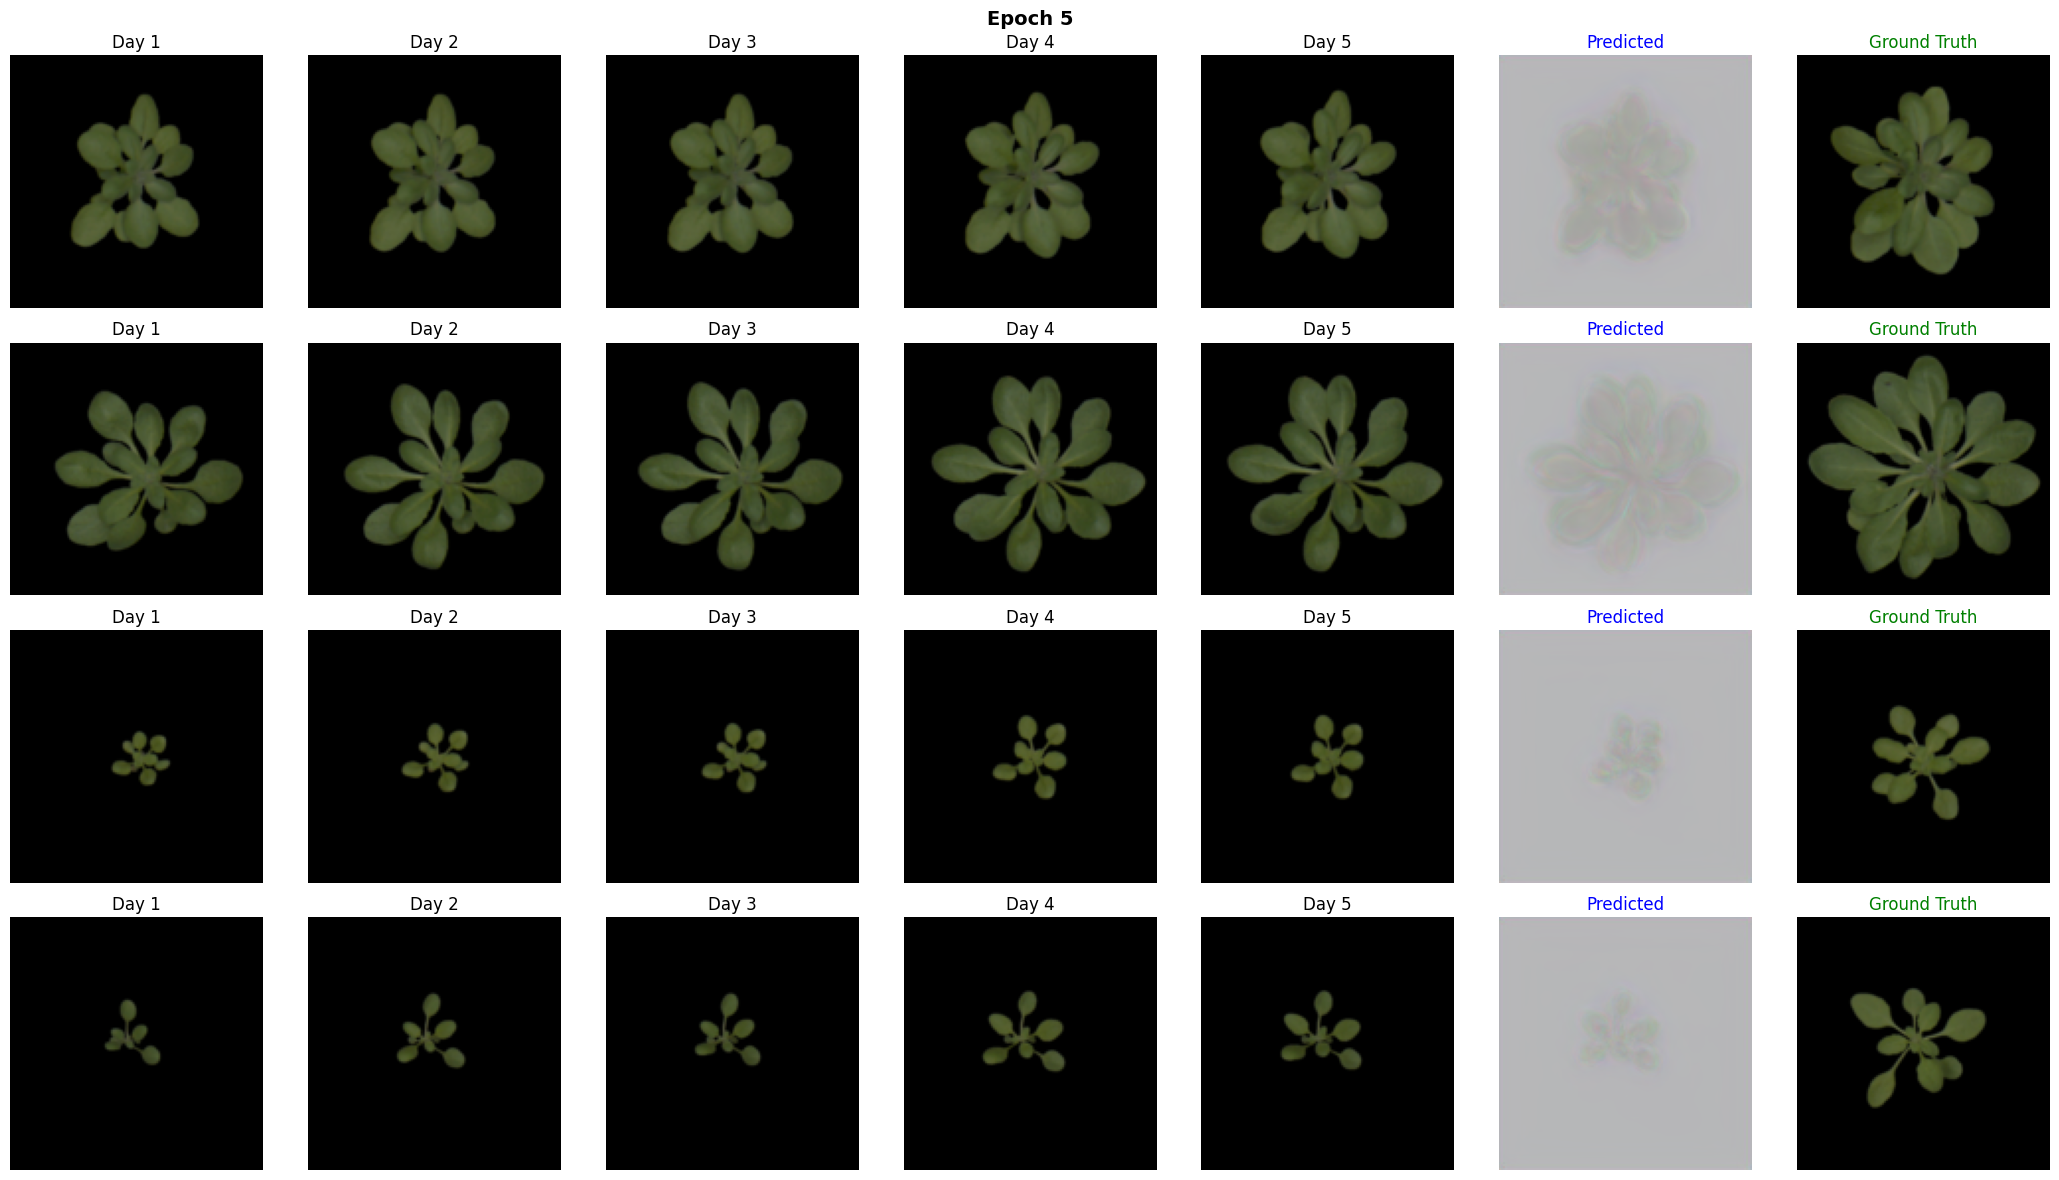


Epoch 6/100


Epoch 6 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8010 | Val Loss: 1.7856 | Val PSNR: 3.45dB 
Best checkpoint saved!

Epoch 7/100


Epoch 7 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
# Create configurations
train_config = TrainConfig()

# Create dataloaders
print("\n Loading data...")
train_loader, val_loader, test_loader = create_dataloaders(data_config)

# Create model
print("\n Creating model...")
model = UNet(n_channels=15, n_classes=3, bilinear=True)
total_params, _ = model.count_parameters()
print(f"Model parameters: {total_params:,}")

# Visualize one batch
inputs, targets, ids = next(iter(train_loader))
print(f"\nBatch shapes: {inputs.shape} -> {targets.shape}")

# START TRAINING
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

trained_model, history = train_model(model, train_loader, val_loader, train_config)

print("ALL DONE!")

# End of Training

In [ ]:
# Load best checkpoint
checkpoint = torch.load(f"{train_config.SAVE_DIR}/checkpoint_best.pth")
trained_model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
print("\n Evaluating on test set...")
device = train_config.DEVICE
trained_model.eval()

test_loss, test_psnr = 0, 0
criterion = CombinedLoss(1.0, 0.0, device)

with torch.no_grad():
    for inputs, targets, _ in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = trained_model(inputs)
        loss, _, _ = criterion(outputs, targets)
        psnr = calculate_psnr(outputs, targets)
        test_loss += loss.item()
        test_psnr += psnr.item()

avg_test_loss = test_loss / len(test_loader)
avg_test_psnr = test_psnr / len(test_loader)

print(f"\n Test Results:")
print(f"   Loss: {avg_test_loss:.4f}")
print(f"   PSNR: {avg_test_psnr:.2f} dB")

# Visualize test predictions
visualize_predictions(trained_model, test_loader, device,
                     epoch=999, save_dir=train_config.VIS_DIR,
                     num_samples=8)

In [ ]:
def predict_single_plant(model, plant_id, data_config, device):
    """Predict growth for a single plant"""
    dataset = PlantGrowthDataset(
        data_config.DATA_ROOT, [plant_id],
        data_config.INPUT_DAYS, data_config.TARGET_DAY,
        data_config.IMG_SIZE, augment=False
    )

    inputs, target, _ = dataset[0]
    inputs = inputs.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(inputs)

    # Plot
    fig, axes = plt.subplots(1, 7, figsize=(21, 3))
    for i in range(5):
        img = denormalize(inputs[0,i]).permute(1,2,0).cpu().numpy()
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f'Day {i+1}')
        axes[i].axis('off')

    pred = denormalize(prediction[0]).permute(1,2,0).cpu().numpy()
    axes[5].imshow(np.clip(pred, 0, 1))
    axes[5].set_title('Predicted Day 10', color='blue', fontweight='bold')
    axes[5].axis('off')

    gt = denormalize(target).permute(1,2,0).cpu().numpy()
    axes[6].imshow(np.clip(gt, 0, 1))
    axes[6].set_title('Ground Truth', color='green', fontweight='bold')
    axes[6].axis('off')

    plt.suptitle(f'Plant {plant_id:02d} Growth Prediction', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example: Predict for plant 5
predict_single_plant(trained_model, plant_id=5,
                    data_config=data_config,
                    device=train_config.DEVICE)